Here I run the entire program without adding any adhesion at all. 
I will then try to add adhesion to where the derivative of the contact forces was positive, as in the other scenario the fact that adding adhesion affected the contact forces was counter productive. 

In [1]:
import os
os.getcwd()
os.chdir('../')


In [2]:
os.getcwd()

'c:\\Users\\lschwitt\\flygym_adhesion-Laetitia'

In [3]:
#pip install -e ."[mujoco]

In [4]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs
from scipy.signal import medfilt


In [5]:

# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left', 'fps' :20},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 8000,#at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')

bool_sum_of_allTarsi = False
window_size_medfilt = 501

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="8000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="8000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="8000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="8000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="8000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="8000"/>] actuators _adhesion


In [6]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / 'tripod_engineered.pkl', 'rb') as f:
    data = pickle.load(f)
with open(data_path / 'behavior' / 'fly_floorwalking_5cycles_tripod.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])
print(2000*0.0005) # 1 second! 

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 6390
Metadata: {'timestep': 0.0001, 'source': 'Analyze_step_data.ipynb'}
1.0


In [8]:
run_time = len(data['joint_RFCoxa'])*nmf.timestep

num_steps_base = int(run_time / nmf.timestep)

In [9]:
# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [10]:
def plot_contact_forces(obs_list_simulation, bool_sum_of_allTarsi = False, window_size_medfilt = 1):
    # tarsi
    if bool_sum_of_allTarsi:
        text_path = 'SumAllTarsi'
        tarsi = np.array(['LFTarsus', 'LMTarsus', 'LHTarsus', 'RFTarsus', 'RMTarsus', 'RHTarsus'])
        contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation]



    else:
        text_path = 'onlyTarsi5'
        tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])
        contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list_simulation]

    assert window_size_medfilt % 2 == 1, "The window size for the median must be an odd integer"
    text_medfilt = ""
    if window_size_medfilt != 1:
        text_medfilt = "Median Filtered"
        

    # Extract the time and fly data for each simulation
    print(len(contact_forces_simulation_noADH))
    time_simulation = np.arange(len(contact_forces_simulation_noADH)) * nmf.timestep





    fig = plt.figure(figsize=(8, 6))

    # Plot data from the first simulation
    plt.plot(time_simulation, medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1)), linewidth=0.8)
    plt.ylabel('Contact Forces', fontsize=8)
    plt.tick_params(labelsize=8)
    #plt.ylim(0, 500)
    if bool_sum_of_allTarsi:
        plt.title(f'Sum of all Tarsi Contact Forces {text_medfilt}', fontsize=9)
    else: 
        plt.title(f'Contact Forces on Tarsi 5 {text_medfilt}', fontsize=9)


    # Create a common legend outside the subplots
    fig.legend(labels=tarsi, loc='center', ncol=len(tarsi), bbox_to_anchor=(0.5, 0), fontsize=8)
    plt.tight_layout()

    fig = plt.gcf() 
    plt.show()
    plt.draw()

    #to save:
    save_path = Path('notebooks/PreRunAdhesionFigures',f'contact_force_{text_path}_{text_medfilt.replace(" ","")}.png')
    fig.savefig(save_path)

In [11]:
n_stabilisation_steps = 1000


# First run: Normal Gravity, no adhesion 

In [13]:
# Run simulation
nmf.physics.model.opt.gravity = (0,0,-9.81e5)
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
#obs_deriv_touch_sensor_Tarsi5 = []
adhesion_obs = []
for i in trange(num_steps + n_stabilisation_steps):
    if i <  n_stabilisation_steps:
        joint_pos = data_block[:, 0] #put back i
    else:
         joint_pos = data_block[:, i- n_stabilisation_steps] #put back i 
    #calculate adhesion
    action = {'joints': joint_pos, 'adhesion': np.zeros(6)} 
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

  0%|          | 0/7390 [00:00<?, ?it/s]

100%|██████████| 7390/7390 [00:12<00:00, 600.03it/s]


In [ ]:
if bool_sum_of_allTarsi:
    contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list]



else:
    contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list]
medfiltered_contact_forces = medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1))
print(np.shape(medfiltered_contact_forces))
derivative = np.gradient(medfiltered_contact_forces,nmf.timestep, axis=0)
print(np.shape(derivative))

adhesion_obs = np.where(np.array(derivative)> 0, 1, 0)
#adhesion_obs[:n_stabilisation_steps] = np.ones(6) 
print(adhesion_obs)

(7391, 6)
(7391, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
"""
windowsize = 501
medfiltered_derivative = medfilt(obs_deriv_touch_sensor_Tarsi5, (windowsize,1))

adhesion_obs = np.where(np.array(medfiltered_derivative)>= 0, 1, 0)
"""

'\nwindowsize = 501\nmedfiltered_derivative = medfilt(obs_deriv_touch_sensor_Tarsi5, (windowsize,1))\n\nadhesion_obs = np.where(np.array(medfiltered_derivative)>= 0, 1, 0)\n'

In [ ]:
#adhesion_obs = np.where(np.array(obs_deriv_touch_sensor_Tarsi5) >= 0, 1, 0)

In [ ]:
prerun_contact = []
for obs in obs_list:
    prerun_contact.append(obs['contact_forces'][4::5])  

In [ ]:
#prerun_deriv = np.copy(obs_deriv_touch_sensor_Tarsi5)

In [ ]:
adhesion_obs

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [15]:
def extract_end_effector_data_xyz(obs_list):
    """
    extract the positional data of the end effectors throughout the simulation. 
    returns dictionary with the x,y,z values of the end effectors
    """

    # Create a list to hold the end effector data len(end_effector_data = 18;)
    end_effector_data = [[] for _ in range(18)]

    # Iterate through each observation in obs_list
    for obs in obs_list:
        end_effectors = obs['end_effectors']

        # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
        for i, value in enumerate(end_effectors):
            end_effector_data[i].append(value)

    end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}
    return end_effector_data

In [33]:
end_effector_data = extract_end_effector_data_xyz(obs_list)

In [14]:
def plot_xyz_pos_endeffectors(end_effector_data):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot 1
    ax1 = axes[0]
    for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
        ax1.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('z-Position end_effectors')

    # Plot 2
    ax2 = axes[1]
    for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
        ax2.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('y-Position end_effectors')

    # Plot 3
    ax3 = axes[2]
    for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
        ax3.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('x-Position end_effectors')
    fig.legend(labels = nmf.end_effector_names, loc = 'center', ncol = len(nmf.end_effector_names), bbox_to_anchor=(0.5,0))
    plt.tight_layout()
    plt.show()



In [ ]:
plot_xyz_pos_endeffectors(end_effector_data)

In [151]:
"""

for grid_idx in np.arange(gridsize): 
    ax1 = fig1.add_subplot(gridsize + 1, nr_axes, grid_idx*nr_axes + 1)
    for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
        ax1.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('z-Position end_effectors')

    ax2 = fig1.add_subplot(gridsize + 1, nr_axes, grid_idx*nr_axes + 2)
    for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
        ax2.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('y-Position end_effectors')

    ax3 = fig1.add_subplot(gridsize + 1, nr_axes, grid_idx*nr_axes + 3)
    for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
        ax3.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('x-Position end_effectors')
"""
import matplotlib.transforms as transforms
def plot_xyz_endeffectors_grid(end_effector_data, fig, gridsize, nr_axes, subfigure_idx, actual_gain_adh):
    """
    end_effector_data: dict returned by the function extract_end_effector_data_xyz
    fig: plt.figure() 
    """
    ax1 = fig.add_subplot(gridsize + 1, nr_axes, subfigure_idx*nr_axes + 1)
    for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
        ax1.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
        ax1.tick_params(labelsize=8)
        #ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('x-position [$\mu$m]',fontsize = 8)
        trans = transforms.blended_transform_factory(ax1.transAxes, ax1.transData)
        ax1.text(0.2, 4000, f'Adhesion Gain:{actual_gain_adh}', transform = trans, fontsize=8,verticalalignment='center', horizontalalignment='center')
        ax1.set_ylim(0,6000)
    ax2 = fig.add_subplot(gridsize + 1, nr_axes, subfigure_idx*nr_axes + 2)
    for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
        ax2.plot(np.arange(len(end_effector)) * nmf.timestep,
                end_effector, linewidth = 0.8)
        ax2.tick_params(labelsize=8)
        #ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('z-position [$\mu$m]', fontsize = 8)
        trans = transforms.blended_transform_factory(ax2.transAxes, ax2.transData)
        ax2.text(0.2, 1400, f'Adhesion Gain: {actual_gain_adh}', transform = trans, fontsize=8, verticalalignment='center', horizontalalignment='center')
        ax2.set_ylim(0,2000)
    if nr_axes == 3:
        ax3 = fig.add_subplot(gridsize + 1, nr_axes, subfigure_idx*nr_axes + 3)
        for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
            ax3.plot(np.arange(len(end_effector)) * nmf.timestep,
                    end_effector, linewidth = 0.8)
            ax3.tick_params(labelsize=8)
            #ax3.set_xlabel('Time (s)')
            ax3.set_ylabel('y-position [$\mu$m]',fontsize = 8)
            trans = transforms.blended_transform_factory(ax3.transAxes, ax3.transData)
            ax3.set_ylim(-1000,5000)

            #ax3.text(0.2, 0.9, f'Adhesion Gain:{actual_gain_adh}', transform = trans, fontsize=8, verticalalignment='center', horizontalalignment='center')
    if subfigure_idx == 0: 
        ax1.set_title('X-Position Tarus 5',fontsize = 8)
        ax2.set_title('Z-Position Tarus 5',fontsize = 8)
        if nr_axes ==3:
            ax3.set_title('Y-Position Tarus 5',fontsize = 8)
    if subfigure_idx == gridsize: 
        ax1.set_xlabel('Time (s)',fontsize = 8)
        ax2.set_xlabel('Time (s)',fontsize = 8)
        if nr_axes ==3:
            ax3.set_xlabel('Time (s)',fontsize = 8)
    return fig






In [152]:
def plot_displacement_grid(obs_list, fig, gridsize, nr_axes, subfigure_idx, actual_gain_adh ,bool_gravity_inv):
    x_thorax_dist = []
    y_thorax_dist = []
    z_thorax_dist = []
    for obs in obs_list:
        x_thorax_dist.append(obs['fly'][0][0])
        y_thorax_dist.append(obs['fly'][0][1])
        z_thorax_dist.append(obs['fly'][0][2])

    #distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)
    if subfigure_idx == 0: 
        ax1 = fig.add_subplot(nr_axes, 1, 1)
        ax1.set_title('X-Distance Thorax',fontsize = 8)
        ax1.tick_params(labelsize=8)
        #ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('x-distance [$\mu$m]',fontsize = 8)
        ax1.set_ylim(0,6000)

        ax2 = fig.add_subplot(nr_axes, 1, 2)
        ax2.set_title('Z-Distance Thorax',fontsize = 8)
        ax2.tick_params(labelsize=8)
        #ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('z-distance [$\mu$m]', fontsize = 8)
        ax2.set_ylim(0,2000)


        if nr_axes ==3:
            ax3 = fig.add_subplot(nr_axes, 1, 3)
            ax3.set_title('Y-Distance Thorax',fontsize = 8)
            ax3.tick_params(labelsize=8)
            #ax3.set_xlabel('Time (s)')
            ax3.set_ylabel('y-distance [$\mu$m]',fontsize = 8)
            ax3.set_ylim(-1000,5000)

    else: 
        axes = fig.get_axes()
        ax1 = axes[0]
        ax2 = axes[1]
        if nr_axes == 3:
            ax3 = axes[2]

    ax1.plot(np.arange(len(x_thorax_dist)) * nmf.timestep,
            x_thorax_dist, linewidth = 0.8, label = f'Adhesion Gain: {actual_gain_adh}\nTotal Distance: {x_thorax_dist[-1] - x_thorax_dist[0]:.1f}'
)
    #ax1.set_ylim(0,6000)

    trans = transforms.blended_transform_factory(ax1.transAxes, ax1.transData)
    #ax1.text(0.2, 4000, f'Adhesion Gain:{actual_gain_adh}\nTotal Distance: {x_thorax_dist[-1]-x_thorax_dist[0]}', transform = trans, fontsize=8,
        #verticalalignment='center', horizontalalignment='center')
    ax1.legend(loc = "right",fontsize = 8)

    ax2.plot(np.arange(len(z_thorax_dist)) * nmf.timestep,
            z_thorax_dist, linewidth = 0.8, label = f'Adhesion Gain:{actual_gain_adh}\nTotal Distance: {z_thorax_dist[-1]-z_thorax_dist[0]:.1f}')
    #ax2.set_ylim(0,6000)
    ax2.legend(loc = "right",fontsize = 8)

    
    trans = transforms.blended_transform_factory(ax2.transAxes, ax2.transData)
    #ax2.text(0.2, 1500, f'Adhesion Gain: {actual_gain_adh}\nTotal Distance: {z_thorax_dist[-1]-z_thorax_dist[0]}', transform = trans, fontsize=8,
    #    verticalalignment='center', horizontalalignment='center')
    
    if nr_axes == 3:
        ax3.plot(np.arange(len(y_thorax_dist)) * nmf.timestep,
                y_thorax_dist, linewidth = 0.8, label = f'Adhesion Gain:{actual_gain_adh}\nTotal Distance: {y_thorax_dist[-1]-y_thorax_dist[0]:.1f}')
        #ax3.set_ylim(0,6000)


        trans = transforms.blended_transform_factory(ax3.transAxes, ax3.transData)
        ax3.legend(loc = "right",fontsize = 8)
        #ax3.text(0.2, 0.9, f'Adhesion Gain:{actual_gain_adh}\nTotal Distance: {y_thorax_dist[-1]-y_thorax_dist[0]}', transform = trans, fontsize=8,
        #    verticalalignment='center', horizontalalignment='center')

    if subfigure_idx == gridsize: 
        ax1.set_xlabel('Time (s)',fontsize = 8)
        ax2.set_xlabel('Time (s)',fontsize = 8)
        if nr_axes ==3:
            ax3.set_xlabel('Time (s)',fontsize = 8)
    return fig



In [82]:
def plot_displacement(obs_list, bool_gravity_inv):
    x_thorax_dist = [obs['fly'][0][0] for obs in obs_list]
    y_thorax_dist = [obs['fly'][0][1] for obs in obs_list]
    z_thorax_dist = [obs['fly'][0][2] for obs in obs_list]
        

    axis = ['x', 'y','z']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    for i, ax in enumerate(axes): 
        #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
        ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
        ax.set_ylabel(axis[i]+ "- thorax position")
        ax.set_xlabel('Time (s)')
    plt.legend()
    plt.subplots_adjust(wspace=0.4)

    # plt.ylabel('x- Position end_effectors')
    if bool_gravity_inv:
        plt.suptitle('... inverted gravity')
    else: 
        plt.suptitle('... gravity normal')

In [ ]:
nmf.actuated_adhesion_bodies[0]

'LFTarsus5'

In [ ]:
np.arange(len(np.array(adhesion_obs)))

array([   0,    1,    2, ..., 7388, 7389, 7390])

Text(0, 0.5, 'adh_val')

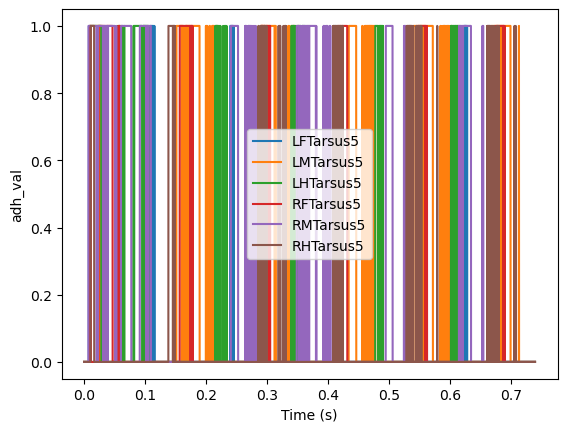

In [ ]:
#calculating adhesion
nr_adhesion_bodies = 6
# nr_adhesion_bodies = 6 if "all"
for i in range(nr_adhesion_bodies):
    plt.plot(np.arange(len(adhesion_obs)) * nmf.timestep,
        adhesion_obs[:,i],
        label=nmf.actuated_adhesion_bodies[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('adh_val')

In [ ]:
touch_sensor_names = []
for touch_sensors in nmf.touch_sensors:
    touch_sensor_names.append(touch_sensors.name)
print(touch_sensor_names)

['touch_LFTarsus1_collision', 'touch_LFTarsus2_collision', 'touch_LFTarsus3_collision', 'touch_LFTarsus4_collision', 'touch_LFTarsus5_collision', 'touch_LMTarsus1_collision', 'touch_LMTarsus2_collision', 'touch_LMTarsus3_collision', 'touch_LMTarsus4_collision', 'touch_LMTarsus5_collision', 'touch_LHTarsus1_collision', 'touch_LHTarsus2_collision', 'touch_LHTarsus3_collision', 'touch_LHTarsus4_collision', 'touch_LHTarsus5_collision', 'touch_RFTarsus1_collision', 'touch_RFTarsus2_collision', 'touch_RFTarsus3_collision', 'touch_RFTarsus4_collision', 'touch_RFTarsus5_collision', 'touch_RMTarsus1_collision', 'touch_RMTarsus2_collision', 'touch_RMTarsus3_collision', 'touch_RMTarsus4_collision', 'touch_RMTarsus5_collision', 'touch_RHTarsus1_collision', 'touch_RHTarsus2_collision', 'touch_RHTarsus3_collision', 'touch_RHTarsus4_collision', 'touch_RHTarsus5_collision']


In [ ]:
touch_sensor_Tarsi5_names = touch_sensor_names[4::5]
print(touch_sensor_Tarsi5_names)

['touch_LFTarsus5_collision', 'touch_LMTarsus5_collision', 'touch_LHTarsus5_collision', 'touch_RFTarsus5_collision', 'touch_RMTarsus5_collision', 'touch_RHTarsus5_collision']


In [ ]:
#np.shape(np.array(obs_deriv_touch_sensor_Tarsi5))

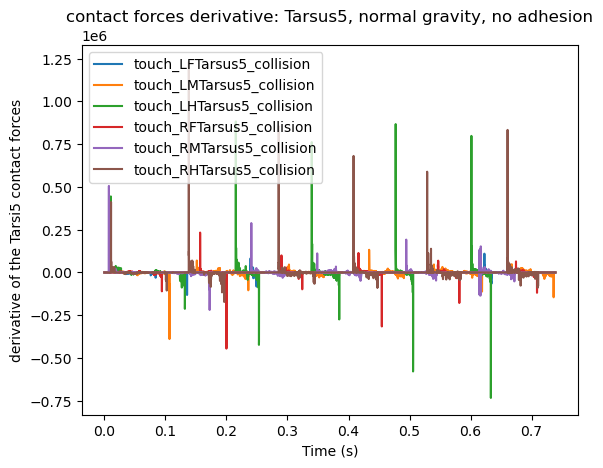

In [ ]:
for i in range(nr_adhesion_bodies):
    plt.plot(np.arange(len(derivative)) * nmf.timestep,
        np.array(derivative)[:,i],
        label=touch_sensor_Tarsi5_names[i])
plt.legend()
plt.xlabel('Time (s)')
if bool_sum_of_allTarsi:
    plt.ylabel('derivative of the sum of all Tarsi contact forces')
    plt.title("contact forces derivative: Tarsus, normal gravity, no adhesion")
else:
    plt.ylabel('derivative of the Tarsi5 contact forces')
    plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

Text(0.5, 0.98, 'before timed adhesion and gravity normal')

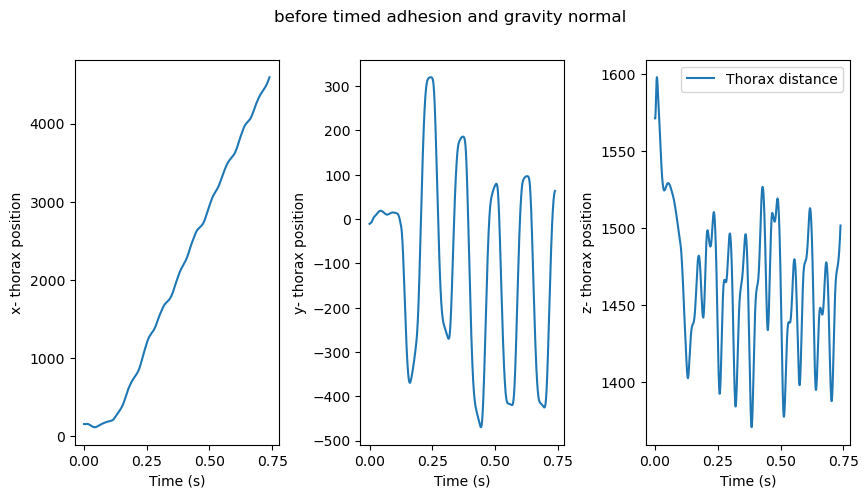

In [ ]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('before timed adhesion and gravity normal')

Calculating the euclidian distance: 


In [ ]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 4439.241693222')

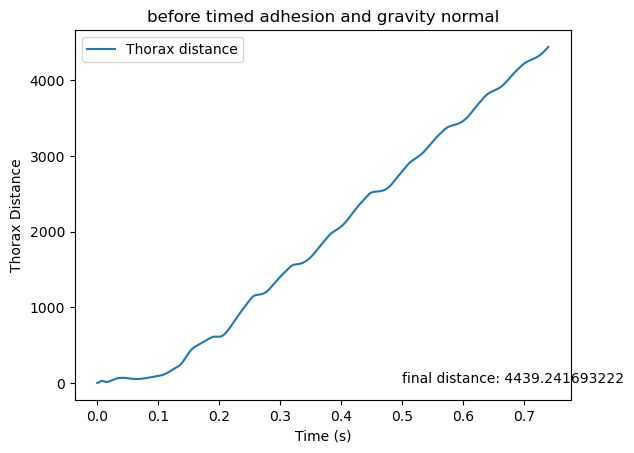

In [ ]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('before timed adhesion and gravity normal')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [ ]:
print(distance_evolution[-1])

4439.241693222


7391


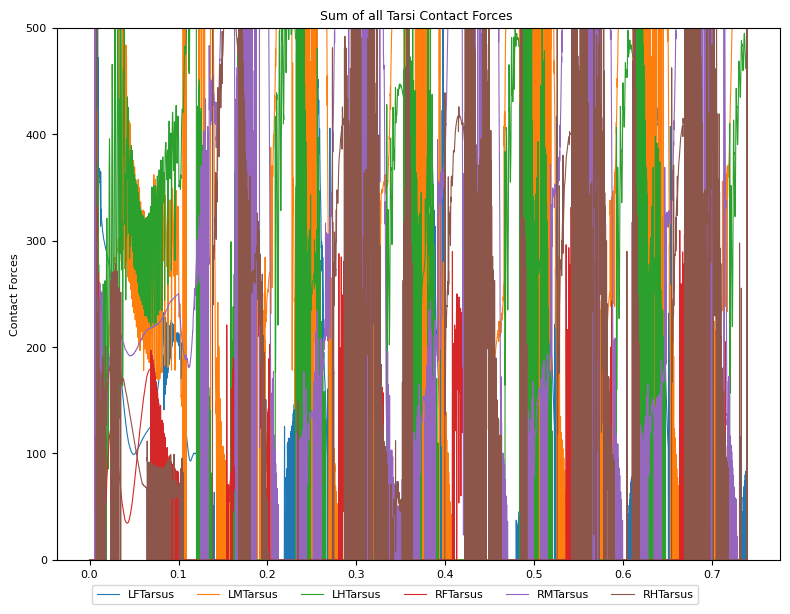

7391


<Figure size 640x480 with 0 Axes>

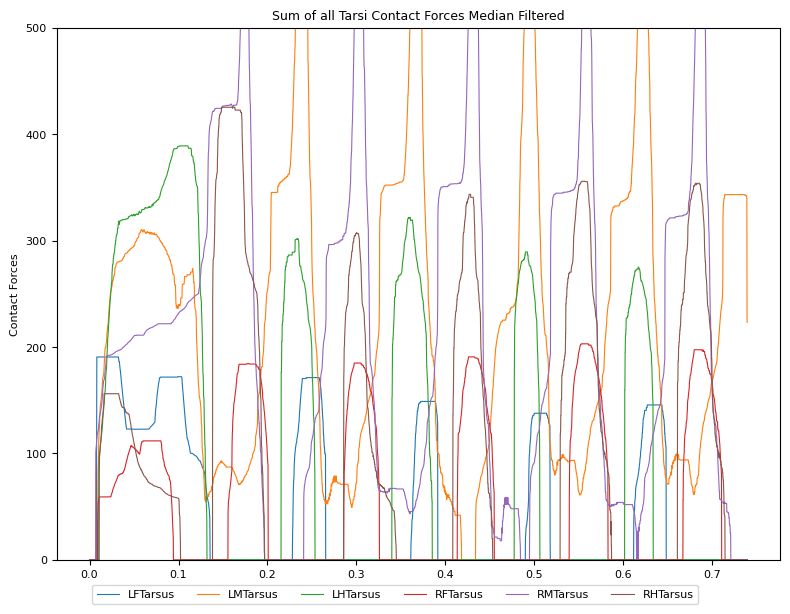

7391


<Figure size 640x480 with 0 Axes>

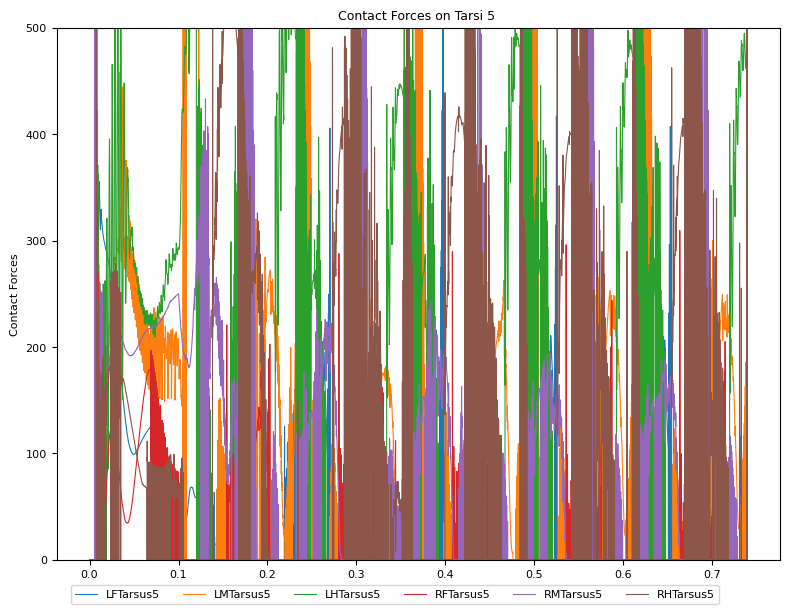

7391


<Figure size 640x480 with 0 Axes>

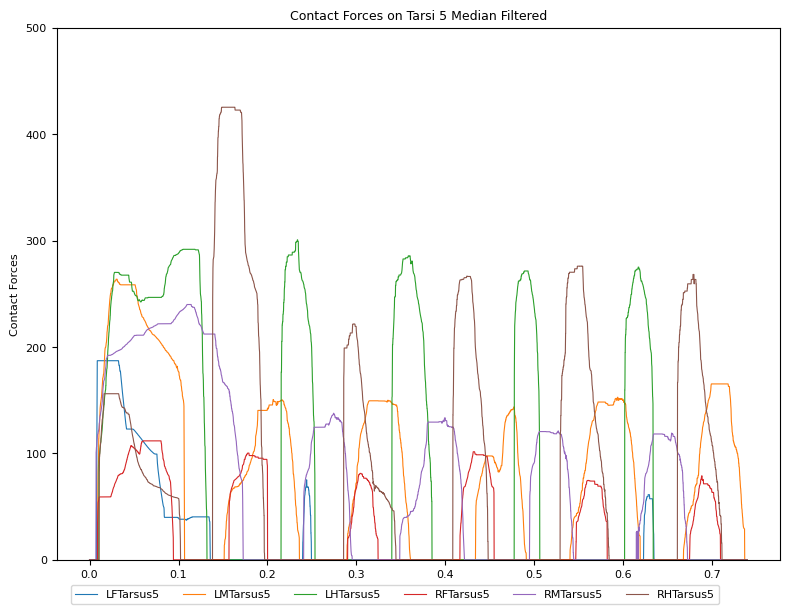

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True, window_size_medfilt= window_size_medfilt)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False, window_size_medfilt=window_size_medfilt)

In [ ]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_NOADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xd36mdat\x00\x…

# 2nd run: Add Adhesion, Gravity still normal

In [ ]:
np.shape(np.array(adhesion_obs))

(7391, 6)

In [150]:
def run_adhesion_sim(nmf, data_block, adhesion_obs, num_steps, n_stabilisation_steps= 1000, bool_gravity_inv = False, adhesion_gain_multiply =1):
    assert adhesion_gain_multiply != 0, "adhesion gain multplier should not be 0"
    # Run simulation
    obs, info = nmf.reset() 
    if bool_gravity_inv:
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    else:
        nmf.physics.model.opt.gravity = (0,0,-9.81e5)
    obs_list = [obs]
    for i in trange(num_steps + n_stabilisation_steps):
        if i < n_stabilisation_steps:
            joint_pos = data_block[:, 0] 
            action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[0,:]}
        else: 

            joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
            #calculate adhesion
            action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[i,:]} 
        obs, info = nmf.step(action)
        
        nmf.render()
        obs_list.append(obs)
    return obs_list

>
True


  0%|          | 0/7390 [00:00<?, ?it/s]

100%|██████████| 7390/7390 [00:06<00:00, 1133.63it/s]


2000.0


100%|██████████| 7390/7390 [00:06<00:00, 1154.69it/s]


4000.0


100%|██████████| 7390/7390 [00:06<00:00, 1118.10it/s]


6000.0


100%|██████████| 7390/7390 [00:06<00:00, 1151.22it/s]


8000.0


100%|██████████| 7390/7390 [00:06<00:00, 1130.84it/s]


16000.0


100%|██████████| 7390/7390 [00:06<00:00, 1147.79it/s]


32000.0


100%|██████████| 7390/7390 [00:06<00:00, 1151.26it/s]


64000.0


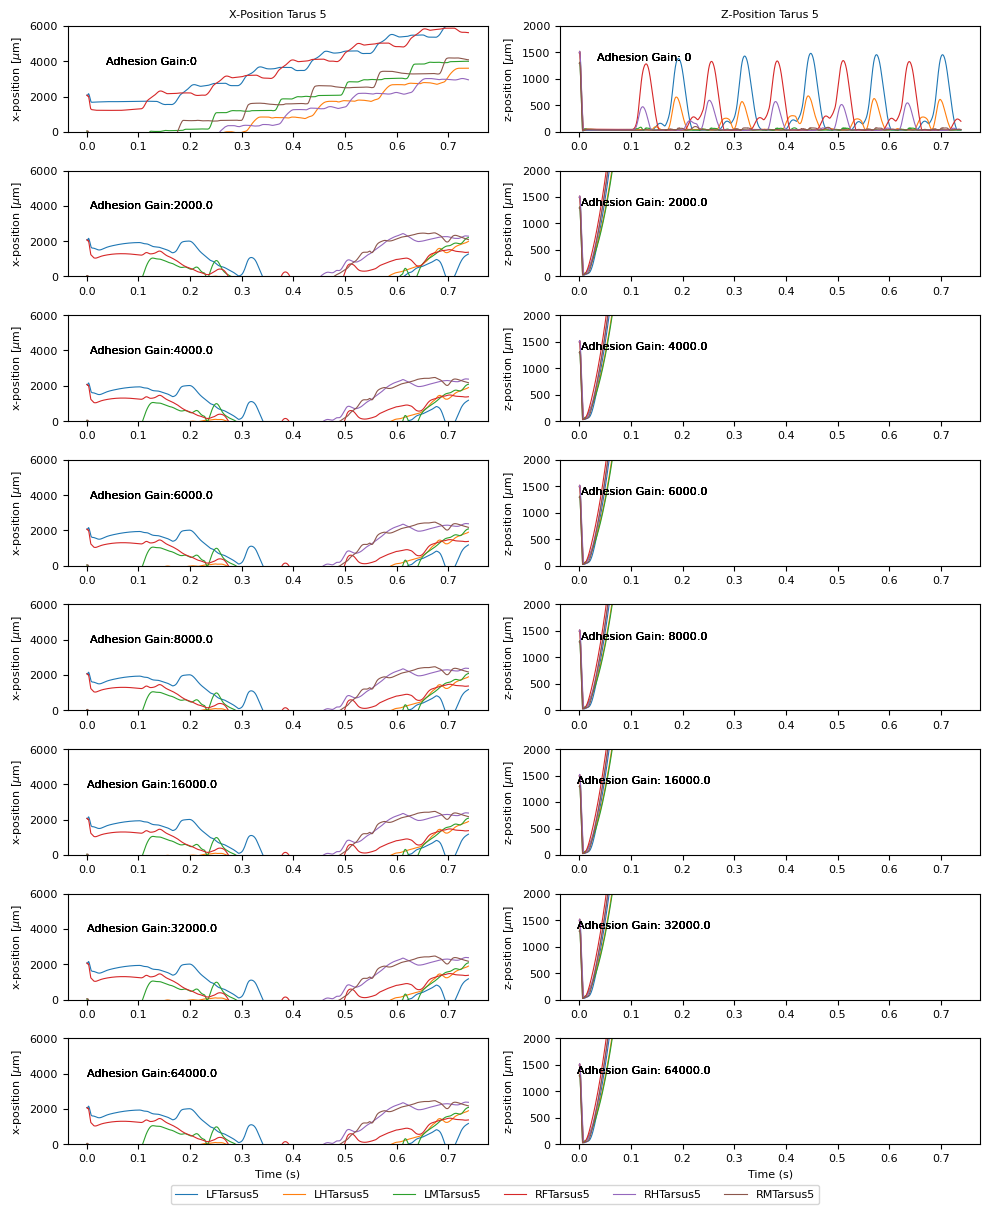

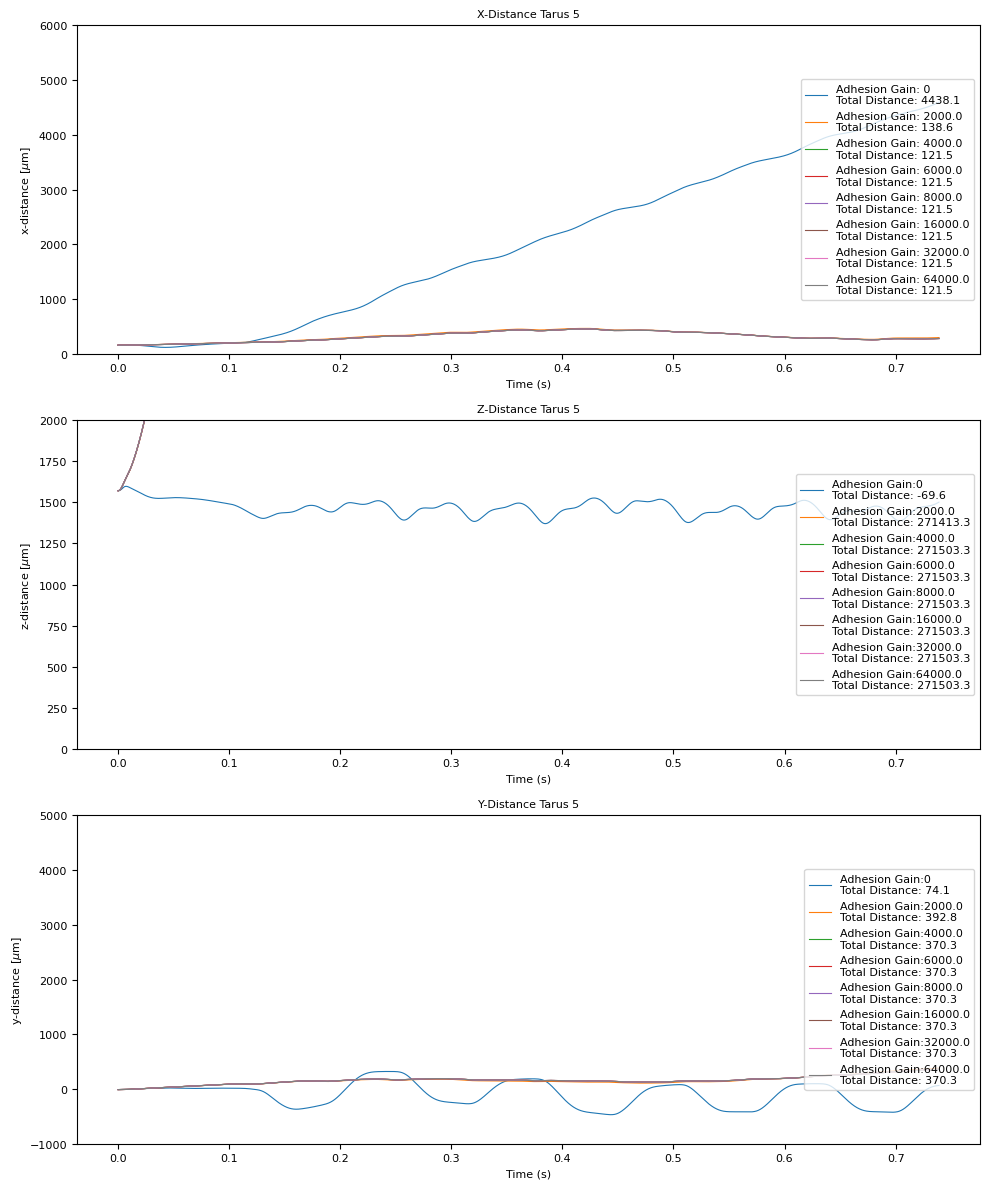

False


100%|██████████| 7390/7390 [00:08<00:00, 879.23it/s] 


2000.0


100%|██████████| 7390/7390 [00:08<00:00, 891.12it/s] 


4000.0


100%|██████████| 7390/7390 [00:08<00:00, 852.31it/s] 


6000.0


100%|██████████| 7390/7390 [00:08<00:00, 856.19it/s] 


8000.0


100%|██████████| 7390/7390 [00:09<00:00, 810.56it/s] 


16000.0


100%|██████████| 7390/7390 [00:08<00:00, 827.68it/s]


32000.0


100%|██████████| 7390/7390 [00:08<00:00, 831.51it/s]


64000.0


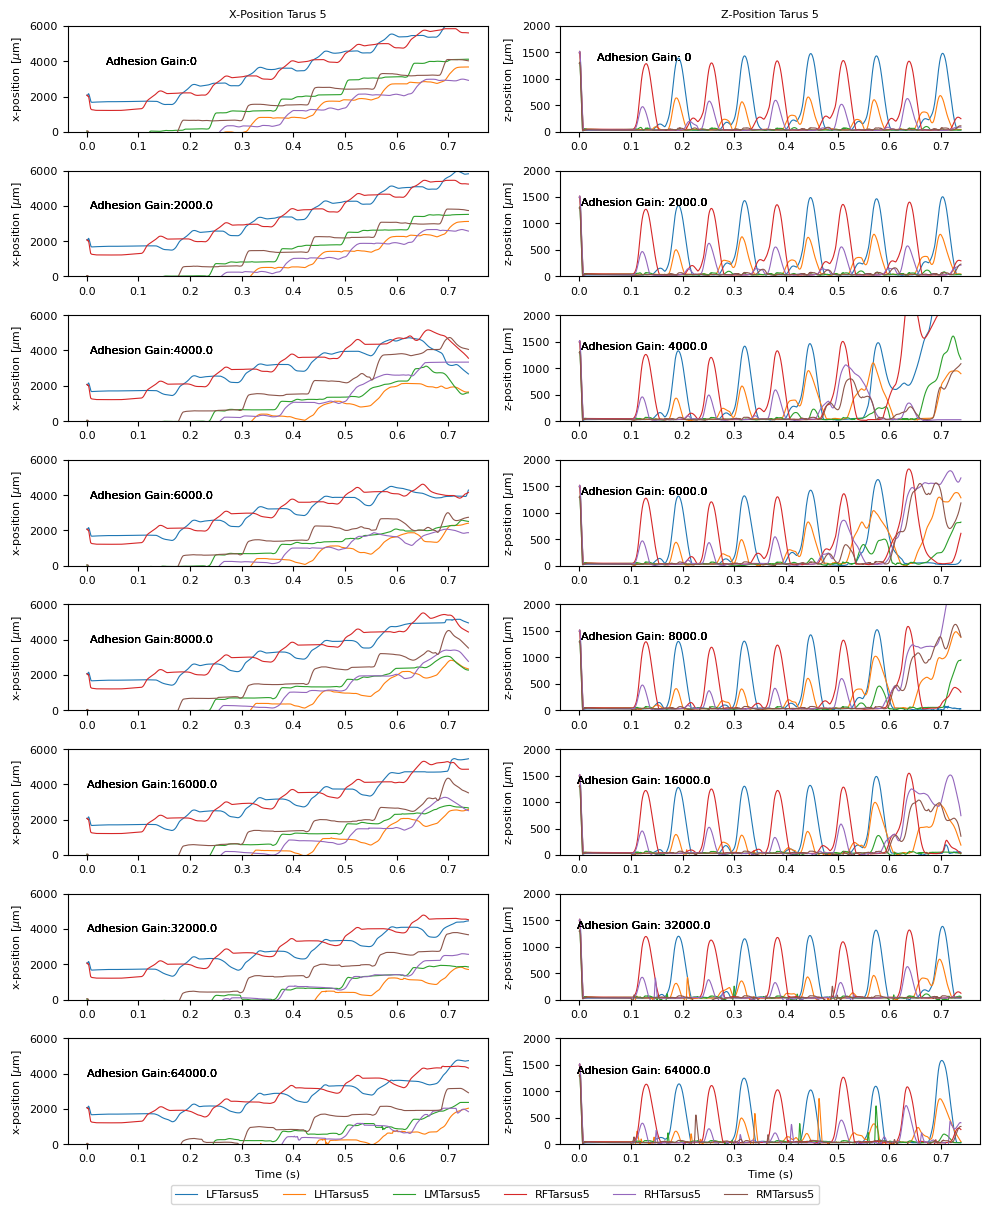

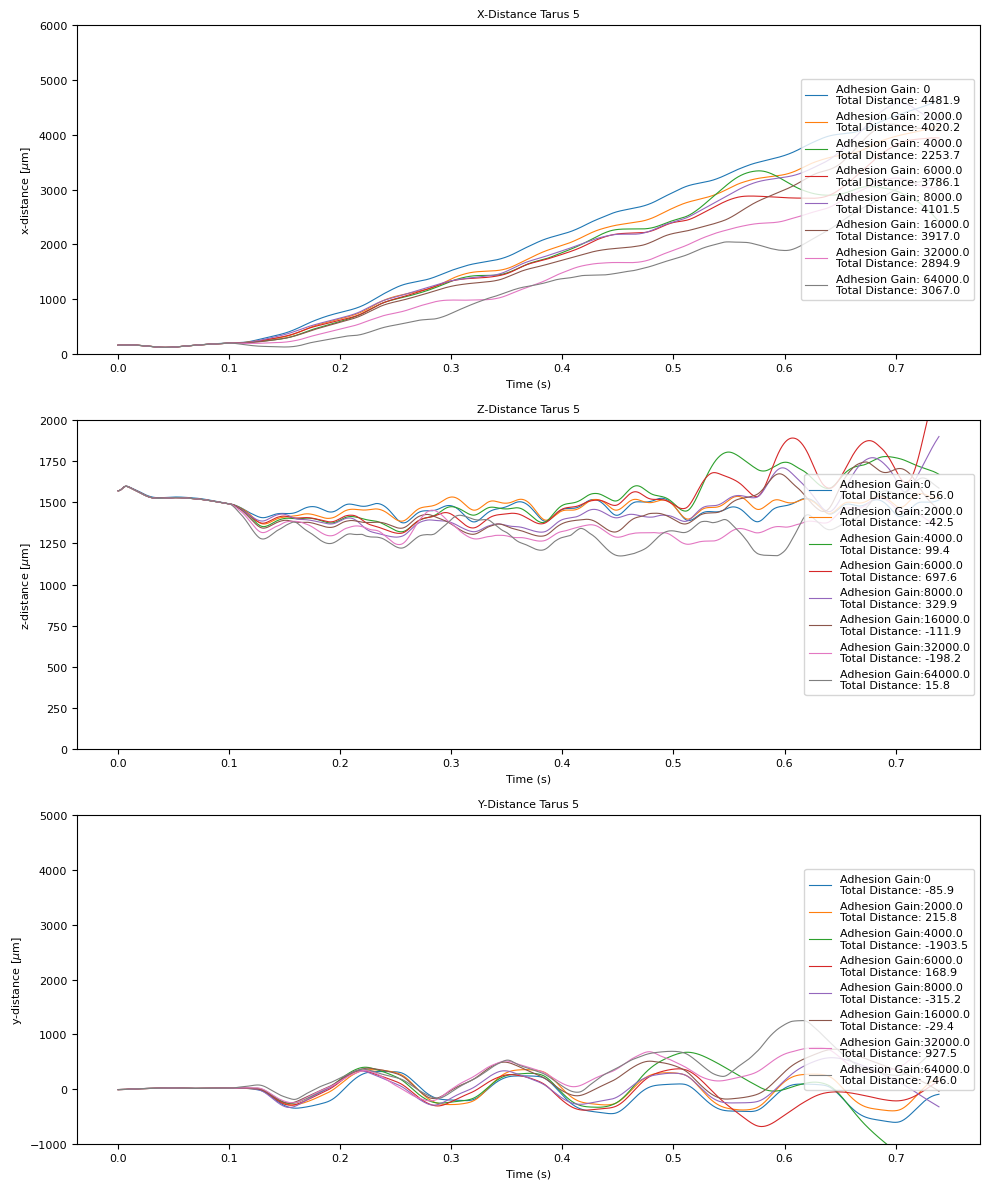

>=
True


100%|██████████| 7390/7390 [00:06<00:00, 1071.49it/s]


2000.0


100%|██████████| 7390/7390 [00:17<00:00, 426.38it/s]


4000.0


100%|██████████| 7390/7390 [00:08<00:00, 821.95it/s] 


6000.0


100%|██████████| 7390/7390 [00:13<00:00, 560.09it/s]


8000.0


100%|██████████| 7390/7390 [00:09<00:00, 807.82it/s] 


16000.0


100%|██████████| 7390/7390 [00:36<00:00, 203.60it/s]


32000.0


100%|██████████| 7390/7390 [00:14<00:00, 501.49it/s] 


64000.0


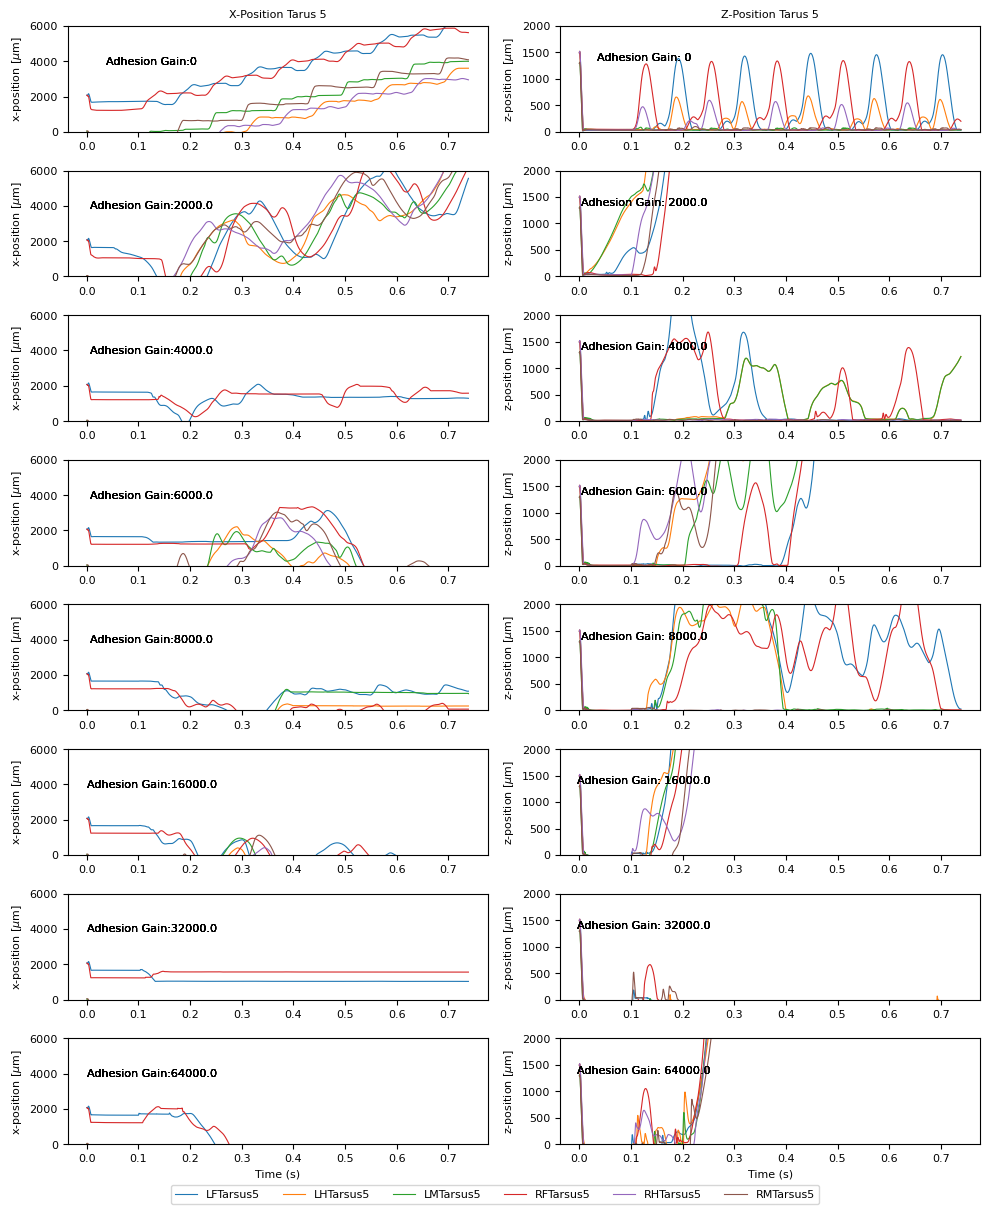

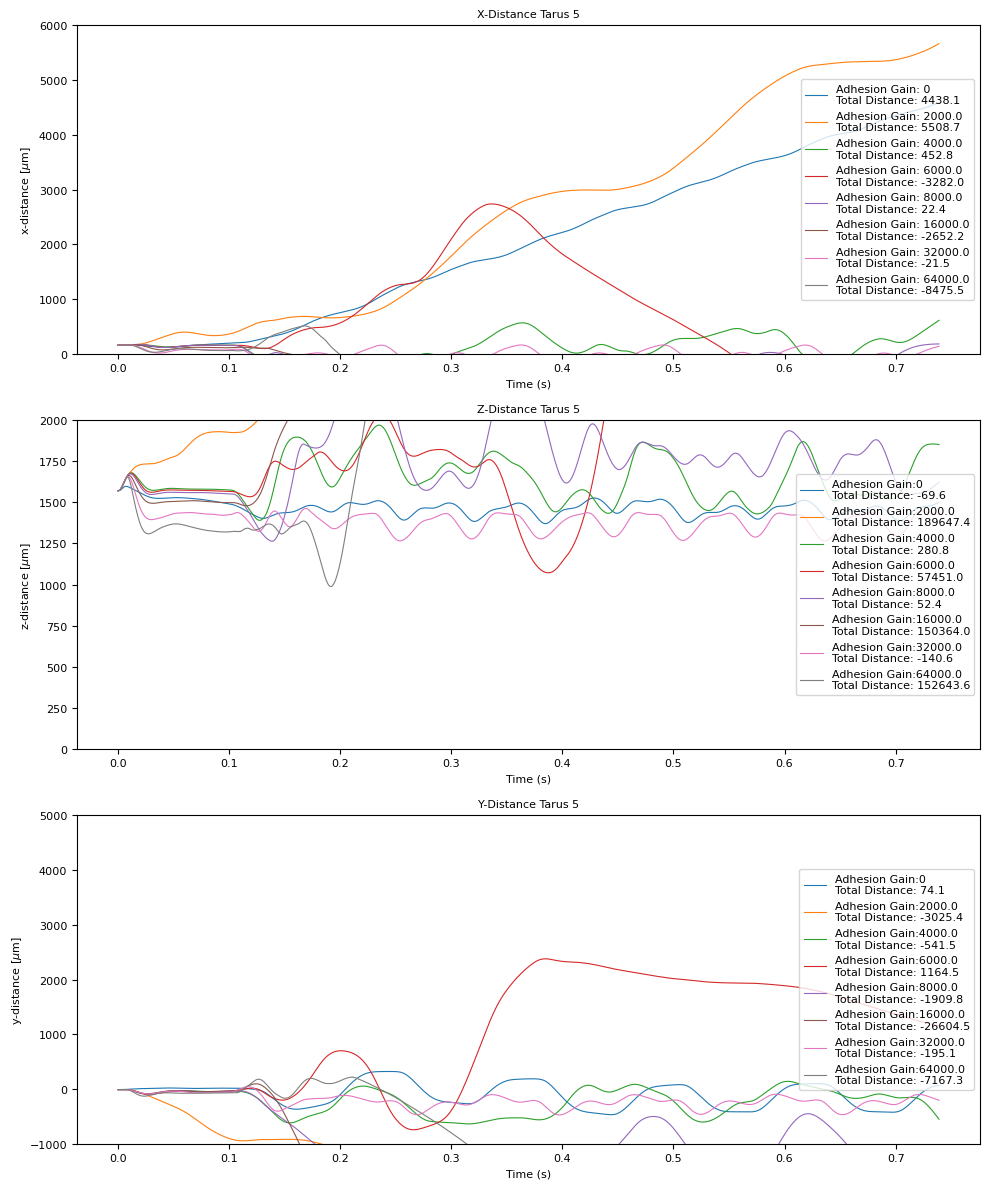

False


100%|██████████| 7390/7390 [00:08<00:00, 824.34it/s] 


2000.0


100%|██████████| 7390/7390 [00:20<00:00, 363.09it/s]


4000.0


100%|██████████| 7390/7390 [00:16<00:00, 451.90it/s]


6000.0


100%|██████████| 7390/7390 [00:18<00:00, 403.58it/s]


8000.0


100%|██████████| 7390/7390 [00:20<00:00, 357.78it/s]


16000.0


100%|██████████| 7390/7390 [00:17<00:00, 426.25it/s] 


32000.0


100%|██████████| 7390/7390 [00:40<00:00, 181.12it/s]


64000.0


In [157]:
adhesion_gain_multipliers = np.array([0.25,0.5,0.75,1,2,4,8])
#adhesion_gain_multipliers = np.array([0.5])

bool_gravity_inv_lists = [True,False]
#bool_gravity_inv = True # False: normal gravity, True: inv gravity
adh_rules = [">", ">="]
#adh_rule = ">="

for adh_rule in adh_rules:
    print(adh_rule)
    for bool_gravity_inv in bool_gravity_inv_lists:
        print(bool_gravity_inv)
        adhesion_obs = np.zeros((num_steps + n_stabilisation_steps,6))

        #for end_effectors figure
        fig_all_endeffectors_grid = plt.figure(figsize=(10,12))
        fig_all_displacements_grid = plt.figure(figsize=(10,12))
        gridsize = len(adhesion_gain_multipliers) # nr of params in the grid (10) + the normal one
        nr_axes_endeffectors = 2
        nr_axes_displacement = 3
        #run no adhesion
        obs_list_noADH = run_adhesion_sim(nmf, data_block, adhesion_obs, num_steps, n_stabilisation_steps, bool_gravity_inv = False, adhesion_gain_multiply=1)
        if bool_sum_of_allTarsi:
            contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list]



        else:
            contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list_noADH]
        medfiltered_contact_forces = medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1))
        derivative = np.gradient(medfiltered_contact_forces,nmf.timestep, axis=0)
        assert adh_rule in adh_rules, "you must add a new adhesion rule"


        end_effector_data_noADH = extract_end_effector_data_xyz(obs_list_noADH)
        #plot_xyz_pos_endeffectors(end_effector_data_noADH)
        fig_all_endeffectors_grid = plot_xyz_endeffectors_grid(end_effector_data_noADH, fig_all_endeffectors_grid, gridsize, nr_axes_endeffectors,subfigure_idx=0, actual_gain_adh=0)
        fig_all_displacements_grid = plot_displacement_grid(obs_list_noADH, fig_all_displacements_grid, gridsize,nr_axes_displacement,subfigure_idx=0, actual_gain_adh=0, bool_gravity_inv=bool_gravity_inv)
        #plot_displacement(obs_list_noADH, bool_gravity_inv = False)

        #run grid
        for i, adhesion_gain_multiplier in enumerate(adhesion_gain_multipliers): 
            if adh_rule == ">":
                adhesion_obs = np.where(np.array(derivative)> 0, 1, 0)
            elif adh_rule == ">=":
                adhesion_obs = np.where(np.array(derivative)>= 0, 1, 0)  
            obs_list = run_adhesion_sim(nmf,data_block,adhesion_obs,num_steps,n_stabilisation_steps,bool_gravity_inv,adhesion_gain_multiplier)
            if bool_sum_of_allTarsi:
                contact_forces_simulation= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list]

            else:
                contact_forces_simulation = [obs['contact_forces'][4::5] for obs in obs_list]
            medfiltered_contact_forces = medfilt(contact_forces_simulation, (window_size_medfilt, 1))
            derivative = np.gradient(medfiltered_contact_forces,nmf.timestep, axis=0)
            assert adh_rule in adh_rules, "you must add a new adhesion rule"
        
            actual_gain_adh = nmf.actuators_adhesion_gain * adhesion_gain_multiplier
            end_effector_data = extract_end_effector_data_xyz(obs_list)
            #plot_xyz_pos_endeffectors(end_effector_data)
            fig_all_endeffectors_grid = plot_xyz_endeffectors_grid(end_effector_data, fig_all_endeffectors_grid, gridsize, nr_axes_endeffectors,subfigure_idx=i + 1,actual_gain_adh=actual_gain_adh)
            fig_all_displacements_grid = plot_displacement_grid(obs_list, fig_all_displacements_grid, gridsize,nr_axes_displacement,subfigure_idx=i+1, actual_gain_adh=actual_gain_adh, bool_gravity_inv=bool_gravity_inv)

            #plot_displacement(obs_list, bool_gravity_inv)
            print(actual_gain_adh)
            
        fig_all_endeffectors_grid.legend(labels = nmf.end_effector_names, loc = 'center', ncol = len(nmf.end_effector_names), bbox_to_anchor=(0.5,0), fontsize = 8)
        #fig_all_endeffectors_grid.text(0.5, 0.04, "time[s]", ha='center', )
        fig_all_endeffectors_grid.tight_layout()
        #fig_all_endeffectors_grid.text(0.04, 0.5, "position", va='center', rotation='vertical')
        plt.figure(fig_all_endeffectors_grid)

        #fig_all_displacements_grid.legend(fontsize = 8)
        #fig_all_endeffectors_grid.text(0.5, 0.04, "time[s]", ha='center', )
        fig_all_displacements_grid.tight_layout()
        #fig_all_endeffectors_grid.text(0.04, 0.5, "position", va='center', rotation='vertical')
        plt.figure(fig_all_displacements_grid)
        plt.show()






gravity on: True
adh_rule, >


  0%|          | 0/7390 [00:00<?, ?it/s]

100%|██████████| 7390/7390 [00:06<00:00, 1137.93it/s]


2000.0


100%|██████████| 7390/7390 [00:06<00:00, 1130.24it/s]


4000.0


100%|██████████| 7390/7390 [00:06<00:00, 1156.75it/s]


6000.0


100%|██████████| 7390/7390 [00:06<00:00, 1150.48it/s]


8000.0


100%|██████████| 7390/7390 [00:06<00:00, 1142.44it/s]


16000.0


100%|██████████| 7390/7390 [00:06<00:00, 1148.09it/s]


32000.0


100%|██████████| 7390/7390 [00:06<00:00, 1136.29it/s]


64000.0


adh_rule, >=


100%|██████████| 7390/7390 [00:06<00:00, 1114.17it/s]


2000.0


100%|██████████| 7390/7390 [00:14<00:00, 520.95it/s]


4000.0


100%|██████████| 7390/7390 [00:17<00:00, 415.71it/s]


6000.0


100%|██████████| 7390/7390 [00:17<00:00, 417.83it/s]


8000.0


100%|██████████| 7390/7390 [00:25<00:00, 293.27it/s]


16000.0


100%|██████████| 7390/7390 [00:35<00:00, 209.49it/s]


32000.0


100%|██████████| 7390/7390 [00:58<00:00, 127.25it/s]


64000.0


gravity on: False
adh_rule, >


100%|██████████| 7390/7390 [00:07<00:00, 952.51it/s] 


2000.0


100%|██████████| 7390/7390 [00:08<00:00, 873.99it/s] 


4000.0


100%|██████████| 7390/7390 [00:07<00:00, 934.32it/s] 


6000.0


100%|██████████| 7390/7390 [00:08<00:00, 886.02it/s] 


8000.0


100%|██████████| 7390/7390 [00:08<00:00, 869.65it/s] 


16000.0


100%|██████████| 7390/7390 [00:08<00:00, 823.11it/s] 


32000.0


100%|██████████| 7390/7390 [00:08<00:00, 872.85it/s] 


64000.0


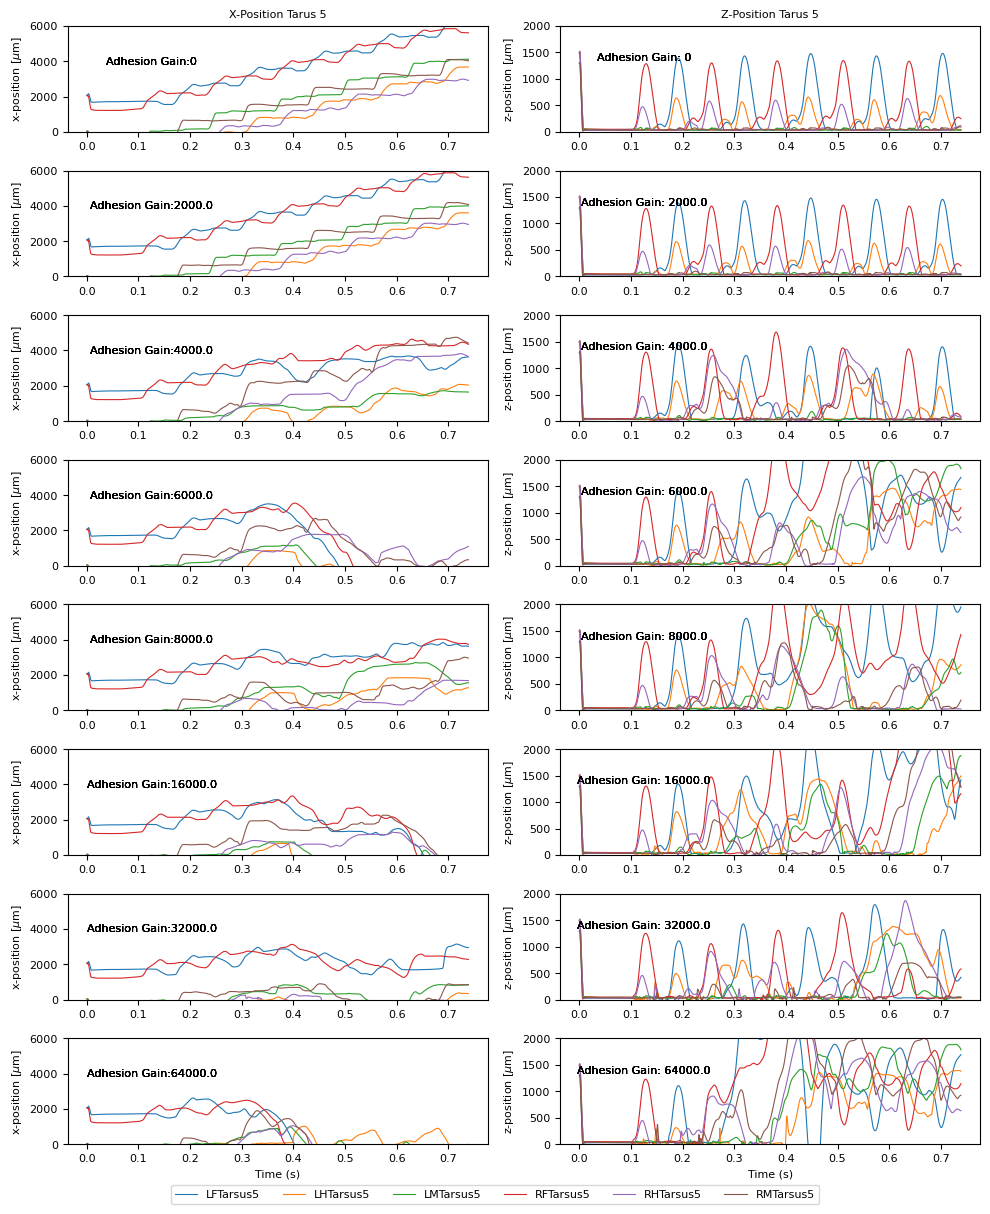

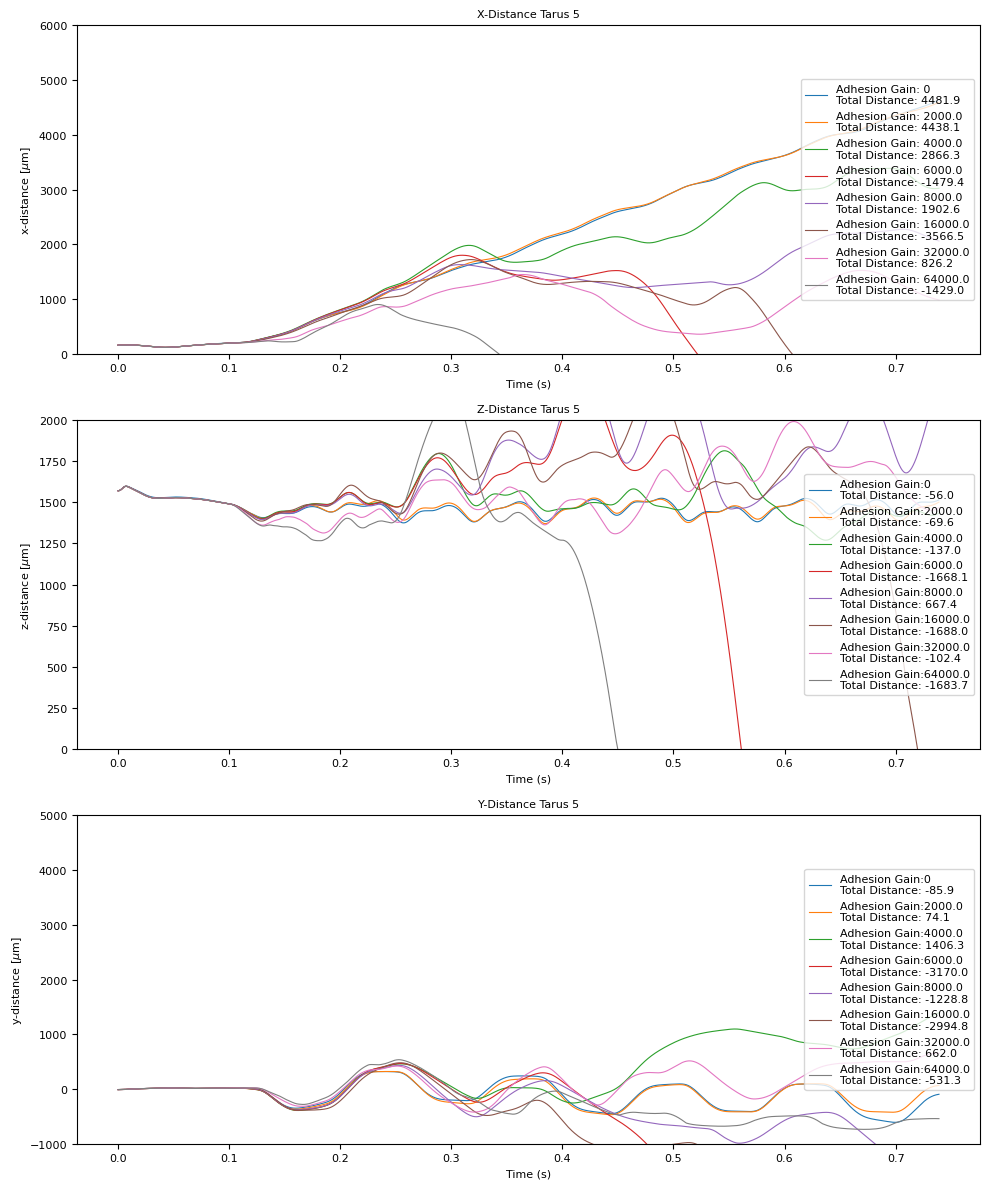

adh_rule, >=


100%|██████████| 7390/7390 [00:07<00:00, 953.43it/s] 


2000.0


100%|██████████| 7390/7390 [00:19<00:00, 370.60it/s]


4000.0


100%|██████████| 7390/7390 [00:19<00:00, 377.72it/s]


6000.0


100%|██████████| 7390/7390 [00:20<00:00, 355.33it/s]


8000.0


100%|██████████| 7390/7390 [00:24<00:00, 299.07it/s]


16000.0


100%|██████████| 7390/7390 [00:31<00:00, 232.81it/s]


32000.0


100%|██████████| 7390/7390 [00:44<00:00, 164.69it/s]


64000.0


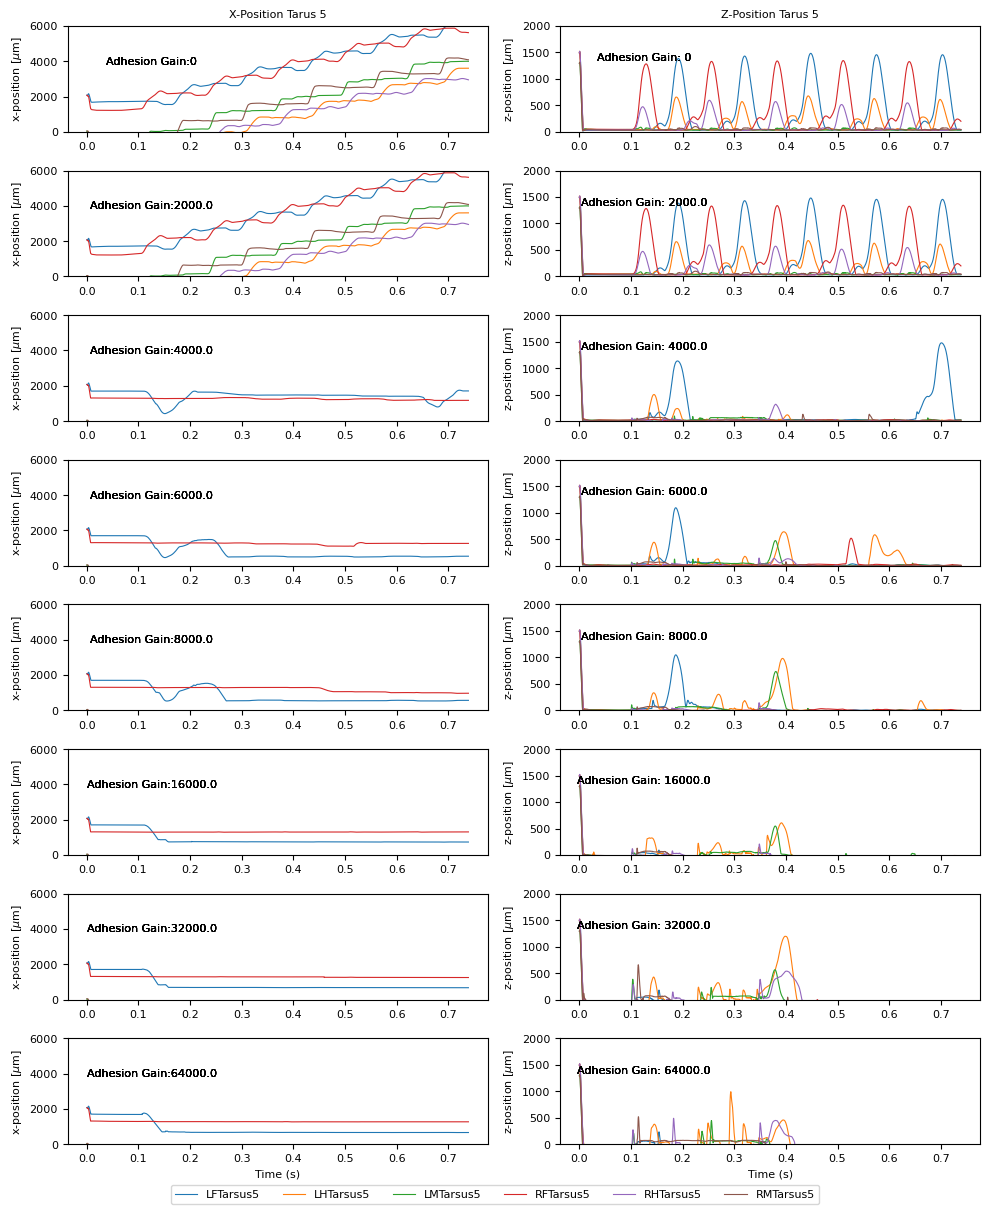

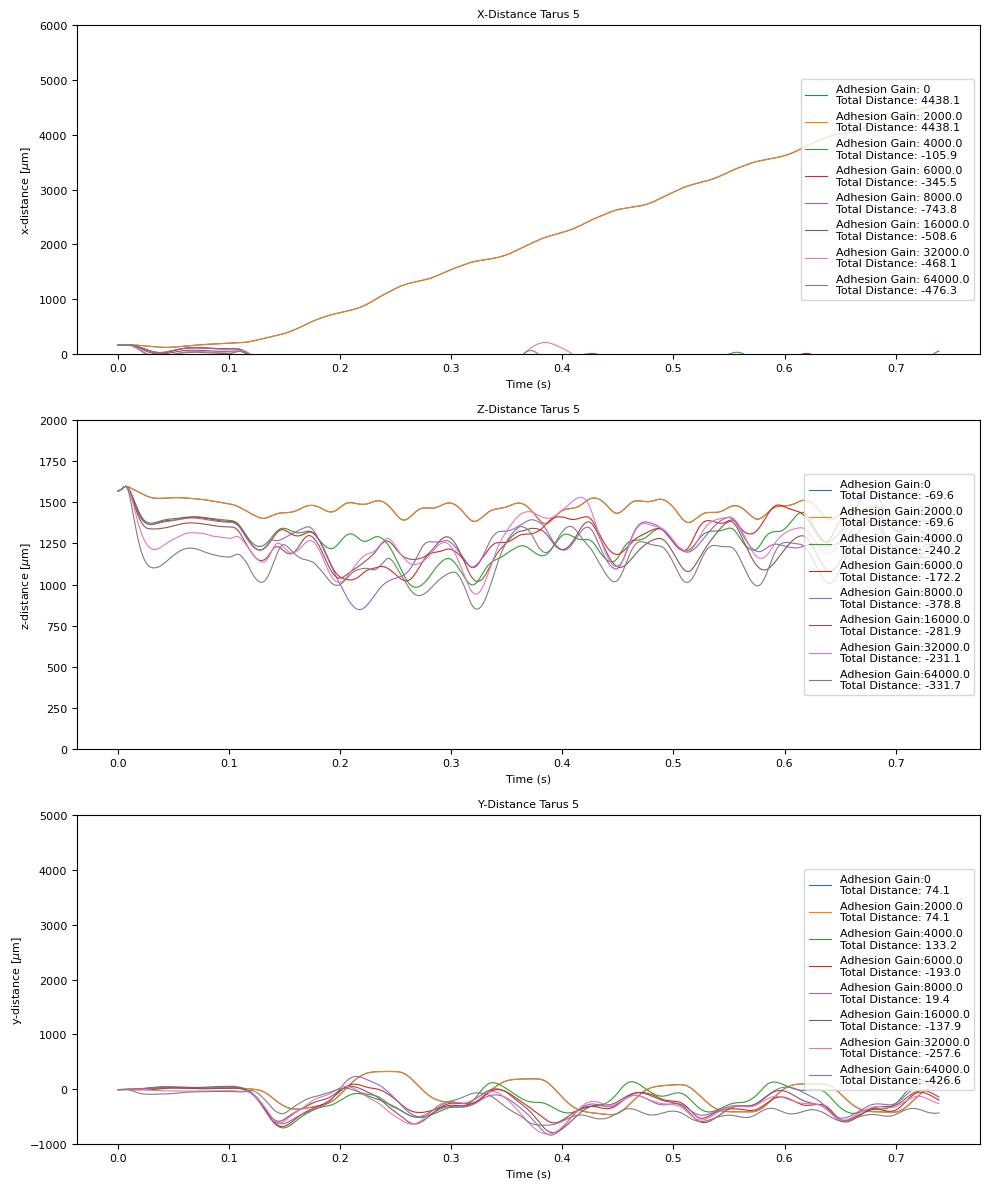

In [ ]:
adhesion_gain_multipliers = np.array([0.25,0.5,0.75,1,2,4,8])
#adhesion_gain_multipliers = np.array([0.5])

adhesion_obs = np.zeros((num_steps + n_stabilisation_steps,6))
bool_gravity_inv_lists = [True, False]
#bool_gravity_inv = True # False: normal gravity, True: inv gravity
adh_rules = [">", ">="]
#adh_rule = ">="
for bool_gravity_inv in bool_gravity_inv_lists:
    print(f"gravity on: {bool_gravity_inv}")
    for adh_rule in adh_rules: 
        print("adh_rule,", adh_rule)
        adhesion_obs = np.zeros((num_steps + n_stabilisation_steps,6))

        #for end_effectors figure
        fig_all_endeffectors_grid = plt.figure(figsize=(10,12))
        fig_all_displacements_grid = plt.figure(figsize=(10,12))
        gridsize = len(adhesion_gain_multipliers) # nr of params in the grid (10) + the normal one
        nr_axes_endeffectors = 2
        nr_axes_displacement = 3
        #run no adhesion
        obs_list_noADH = run_adhesion_sim(nmf, data_block, adhesion_obs, num_steps, n_stabilisation_steps, bool_gravity_inv = False, adhesion_gain_multiply=1)
        end_effector_data_noADH = extract_end_effector_data_xyz(obs_list_noADH)
        #plot_xyz_pos_endeffectors(end_effector_data_noADH)
        fig_all_endeffectors_grid = plot_xyz_endeffectors_grid(end_effector_data_noADH, fig_all_endeffectors_grid, gridsize, nr_axes_endeffectors,subfigure_idx=0, actual_gain_adh=0)
        fig_all_displacements_grid = plot_displacement_grid(obs_list_noADH, fig_all_displacements_grid, gridsize,nr_axes_displacement,subfigure_idx=0, actual_gain_adh=0, bool_gravity_inv=bool_gravity_inv)
        #plot_displacement(obs_list_noADH, bool_gravity_inv = False)

        if bool_sum_of_allTarsi:
            contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_noADH]

        else:
            contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list]
        medfiltered_contact_forces = medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1))
        derivative = np.gradient(medfiltered_contact_forces,nmf.timestep, axis=0)

        #run grid
        for i, adhesion_gain_multiplier in enumerate(adhesion_gain_multipliers): 
            obs_list = run_adhesion_sim(nmf,data_block,adhesion_obs,num_steps,n_stabilisation_steps,bool_gravity_inv,adhesion_gain_multiplier)

            assert adh_rule in adh_rules, "you must add a new adhesion rule"

            if adh_rule == ">":
                adhesion_obs = np.where(np.array(derivative)> 0, 1, 0)
            elif adh_rule == ">=":
                adhesion_obs = np.where(np.array(derivative)>= 0, 1, 0)    
            actual_gain_adh = nmf.actuators_adhesion_gain * adhesion_gain_multiplier
            end_effector_data = extract_end_effector_data_xyz(obs_list)
            #plot_xyz_pos_endeffectors(end_effector_data)
            fig_all_endeffectors_grid = plot_xyz_endeffectors_grid(end_effector_data, fig_all_endeffectors_grid, gridsize, nr_axes_endeffectors,subfigure_idx=i + 1,actual_gain_adh=actual_gain_adh)
            fig_all_displacements_grid = plot_displacement_grid(obs_list, fig_all_displacements_grid, gridsize,nr_axes_displacement,subfigure_idx=i+1, actual_gain_adh=actual_gain_adh, bool_gravity_inv=bool_gravity_inv)

            #plot_displacement(obs_list, bool_gravity_inv)
            print(actual_gain_adh)
            
        fig_all_endeffectors_grid.legend(labels = nmf.end_effector_names, loc = 'center', ncol = len(nmf.end_effector_names), bbox_to_anchor=(0.5,0), fontsize = 8)
        #fig_all_endeffectors_grid.text(0.5, 0.04, "time[s]", ha='center', )
        fig_all_endeffectors_grid.tight_layout()
        #fig_all_endeffectors_grid.text(0.04, 0.5, "position", va='center', rotation='vertical')
        plt.figure(fig_all_endeffectors_grid)

        #fig_all_displacements_grid.legend(fontsize = 8)
        #fig_all_endeffectors_grid.text(0.5, 0.04, "time[s]", ha='center', )
        fig_all_displacements_grid.tight_layout()
        #fig_all_endeffectors_grid.text(0.04, 0.5, "position", va='center', rotation='vertical')
        plt.figure(fig_all_displacements_grid)
        plt.show()






In [ ]:
# Run simulation
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
for i in trange(num_steps + n_stabilisation_steps):
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        action = {'joints': joint_pos, 'adhesion': np.array(adhesion_obs)[i,:]} 

    else:
        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': np.array(adhesion_obs)[i,:]} 
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

100%|██████████| 7390/7390 [00:14<00:00, 512.04it/s]


In [ ]:
afterrun_contact = []
for obs in obs_list:
    afterrun_contact.append(obs['contact_forces'][4::5])  

In [ ]:
diff = np.array(prerun_contact) - np.array(afterrun_contact)

In [ ]:
diff

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 71.49096814, 105.97689528, 488.52703532,   0.        ,
          0.        ,   0.        ],
       [ 71.88558721,   0.        , 488.71443423,   0.        ,
          0.        ,   0.        ],
       [ 72.55225034,  74.49992634, 488.12691965,   0.        ,
          0.        , 627.21048439]])

In [34]:
end_effector_data = extract_end_effector_data_xyz(obs_list)

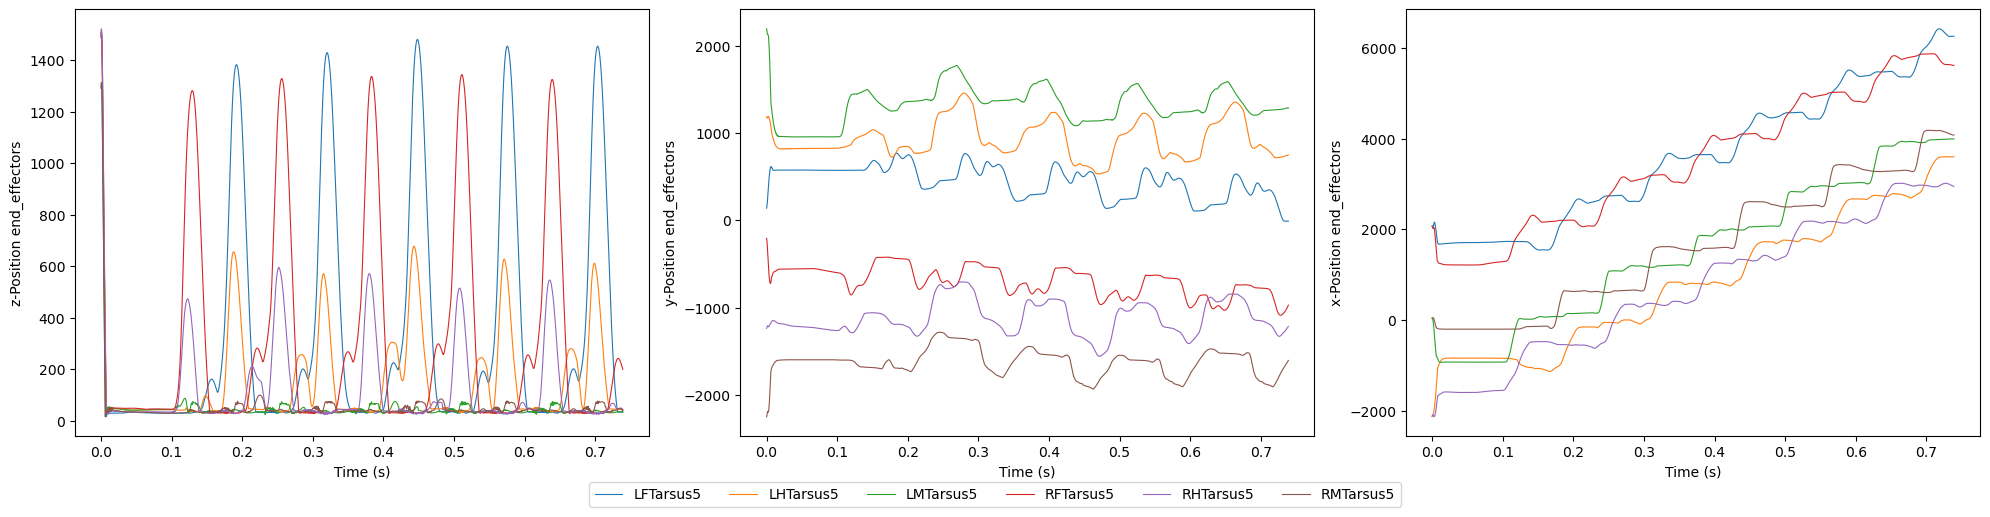

In [35]:
plot_xyz_pos_endeffectors(end_effector_data)

Text(0.5, 0.98, 'after timed adhesion and gravity normal')

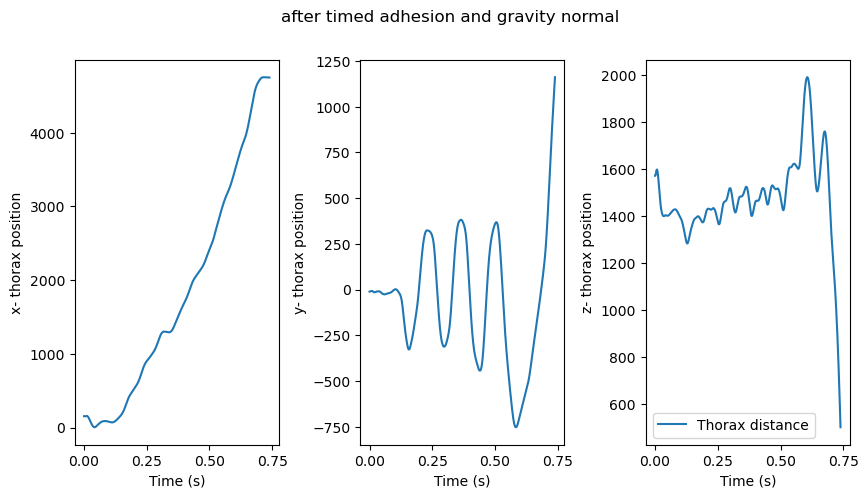

In [ ]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('after timed adhesion and gravity normal')

Calculating the euclidian distance: 


In [ ]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 4858.515306286937')

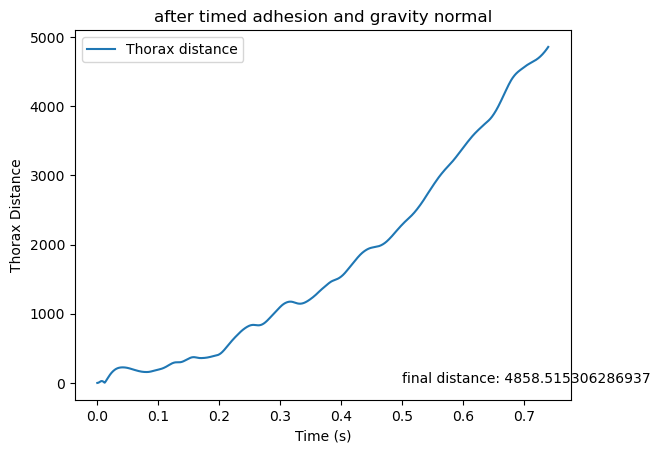

In [ ]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity normal')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

7391


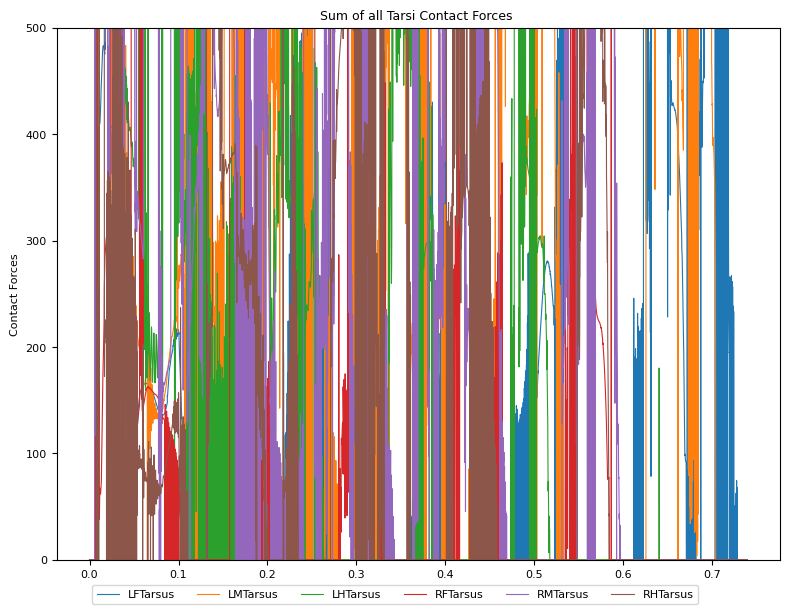

7391


<Figure size 640x480 with 0 Axes>

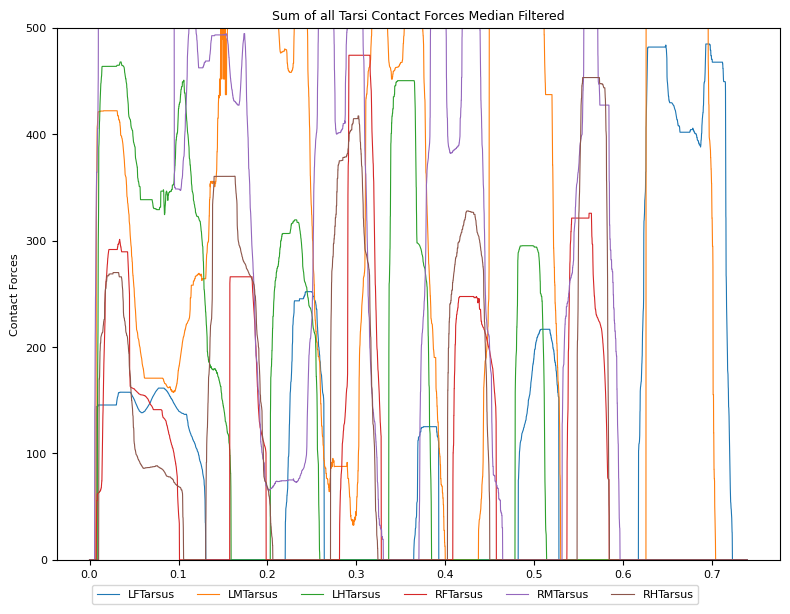

7391


<Figure size 640x480 with 0 Axes>

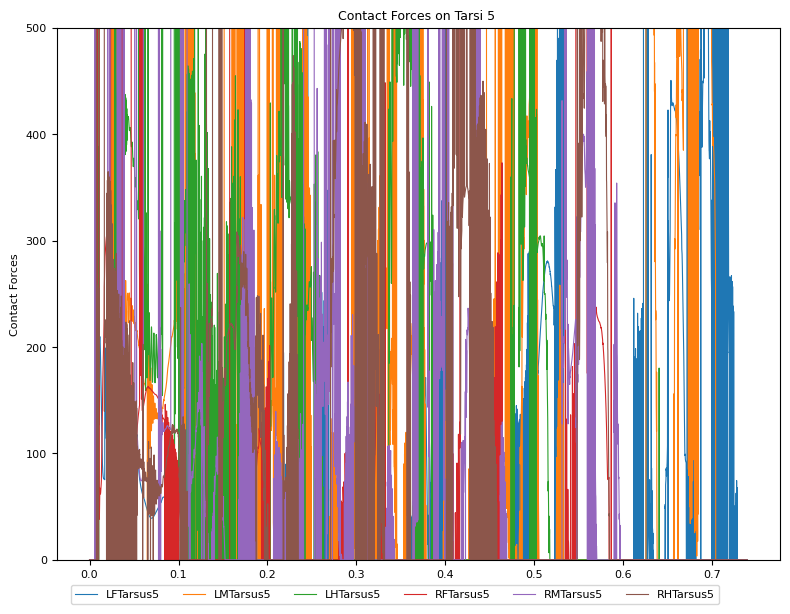

7391


<Figure size 640x480 with 0 Axes>

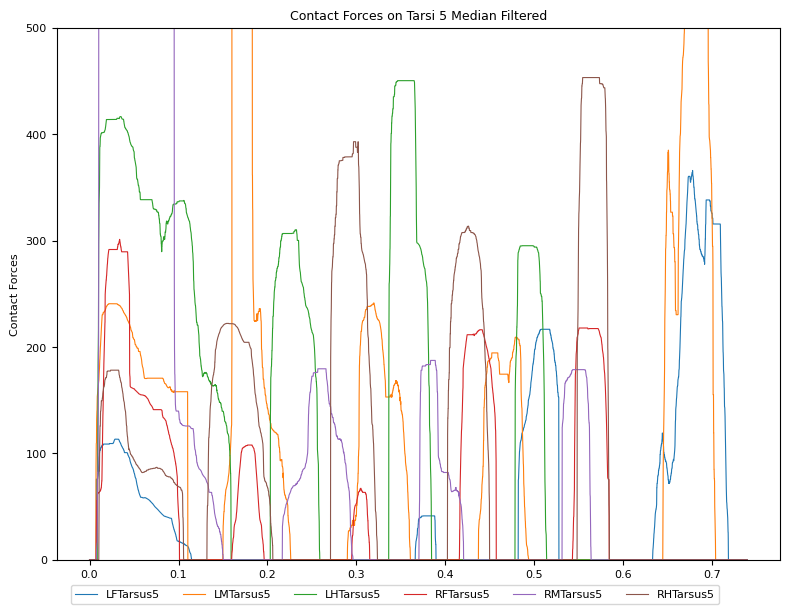

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True, window_size_medfilt= window_size_medfilt)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False, window_size_medfilt=window_size_medfilt)

In [ ]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_ADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x06XJmdat\x00\x00\…

# 3nd run: Add Adhesion, Gravity inverted 

In [ ]:
#so that the fly doesnt directly fly away.
adhesion_obs = np.where(np.array(derivative)>= 0, 1, 0)
adhesion_obs[:n_stabilisation_steps] = np.ones(6) 


In [ ]:
# Run simulation
obs, info = nmf.reset() 
nmf.physics.model.opt.gravity = (0,0,9.81e5)
adhesion_gain_multiply = 20
old_obs = obs
obs_list = [obs]
for i in trange(num_steps + n_stabilisation_steps):
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[0,:]}
    else: 

        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[i,:]} 
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

100%|██████████| 7390/7390 [00:59<00:00, 124.73it/s]


In [ ]:
end_effector_data = extract_end_effector_data_xyz(obs_list)

In [ ]:
#plotting end_effector_data
plot_xyz_pos_endeffectors(end_effector_data)

In [ ]:
afterrun_inv_grav_contact = []
for obs in obs_list:
    afterrun_inv_grav_contact.append(obs['contact_forces'][4::5])  

In [ ]:
diff = np.array(prerun_contact) - np.array(afterrun_inv_grav_contact)

# Thorax displacement 

Text(0.5, 0.98, 'after timed adhesion and gravity inverted')

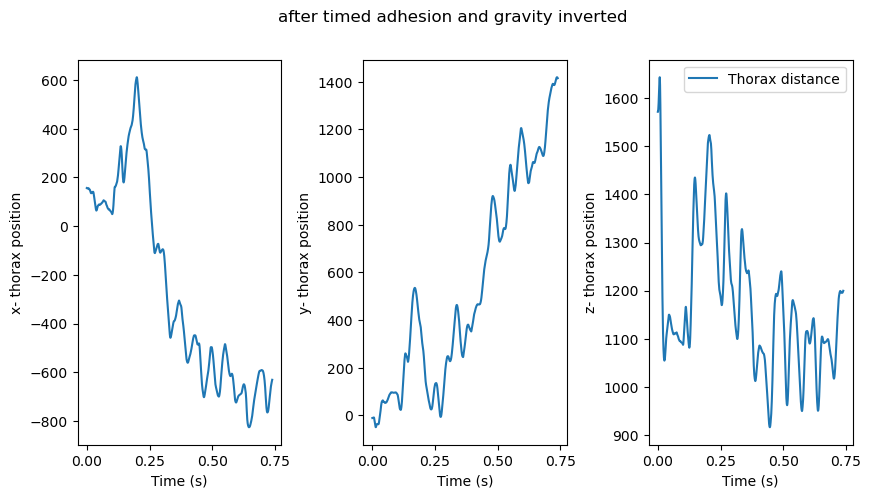

In [ ]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('after timed adhesion and gravity inverted')

Calculating the euclidian distance: 


In [ ]:
obs_list[0]['fly']

array([[ 1.56515377e+02, -1.06738401e+01,  1.57142617e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.57063908e+00,  2.07869279e-04,  9.09672773e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Text(0.5, 0.5, 'final distance: -787.4185127948008')

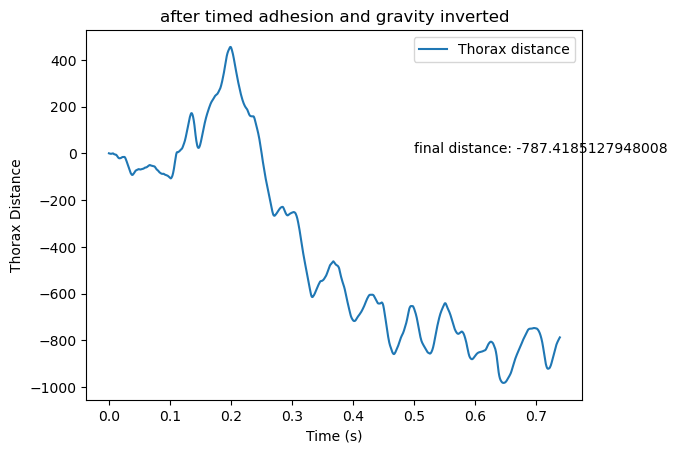

In [ ]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)
x_distance_evolution = [obs['fly'][0][0] - obs_list[0]['fly'][0][0] for obs in obs_list]

plt.plot(np.arange(len(x_distance_evolution)) * nmf.timestep,
    x_distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity inverted')
plt.text(0.5, 0.5, f"final distance: {x_distance_evolution[-1]}")

Text(0.5, 0.5, 'final distance: 1670.5237603425974')

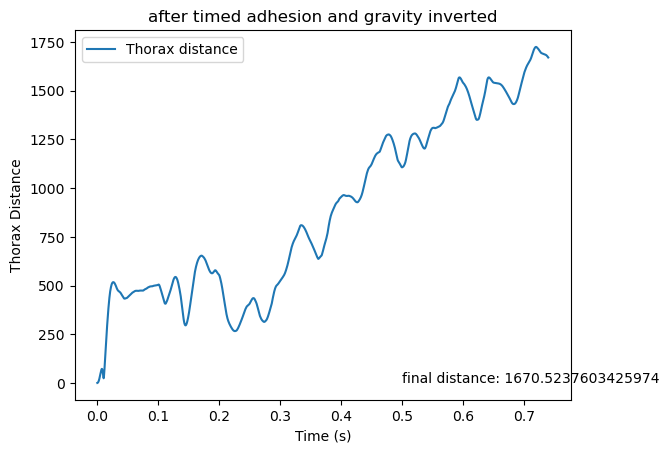

In [ ]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity inverted')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [ ]:
print(distance_evolution[-1])

1670.5237603425974


In [ ]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_ADHESION_INVGrav.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05MOmdat\x00\x00\…

7391


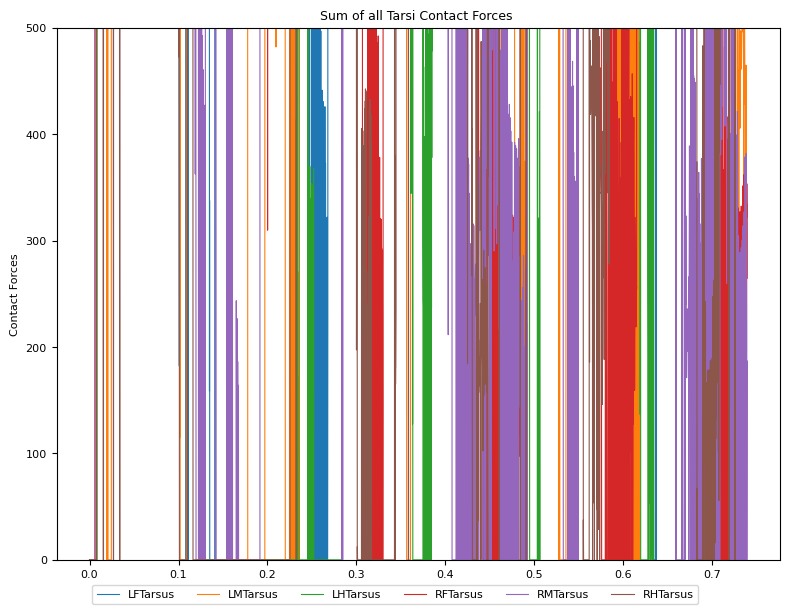

7391


<Figure size 640x480 with 0 Axes>

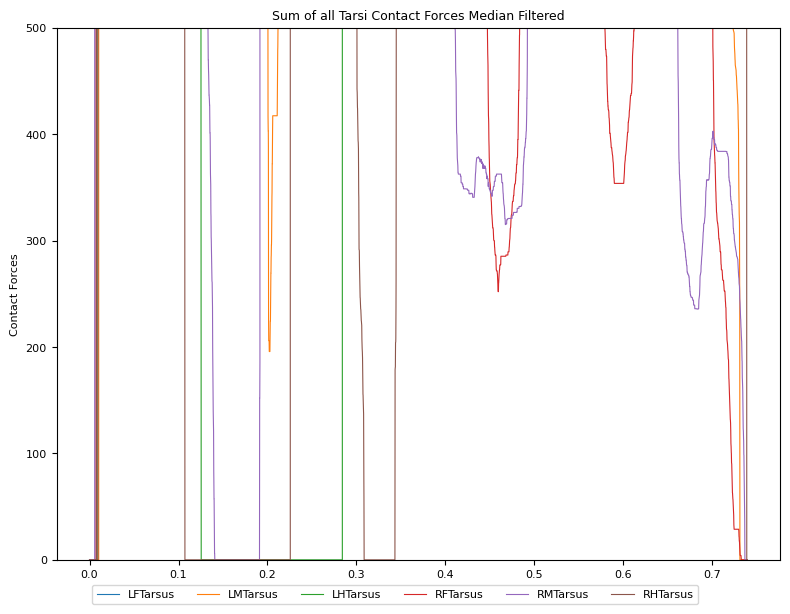

7391


<Figure size 640x480 with 0 Axes>

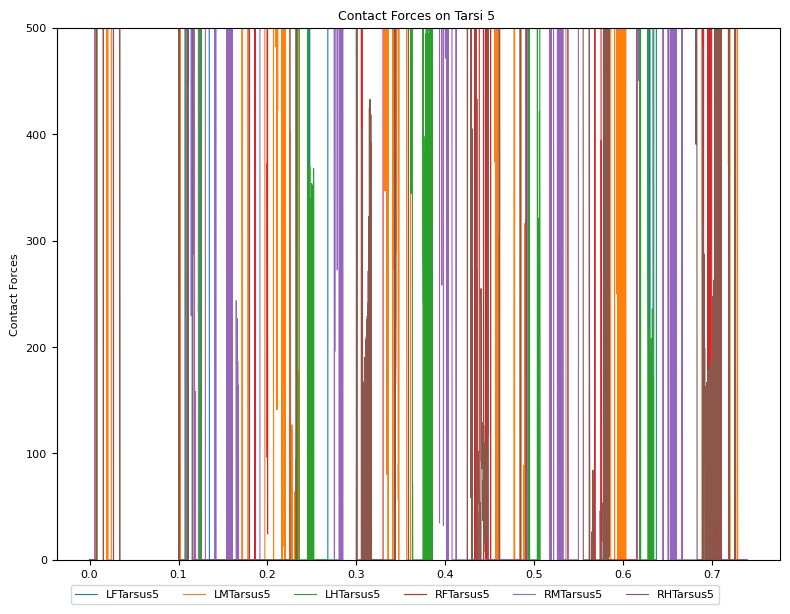

7391


<Figure size 640x480 with 0 Axes>

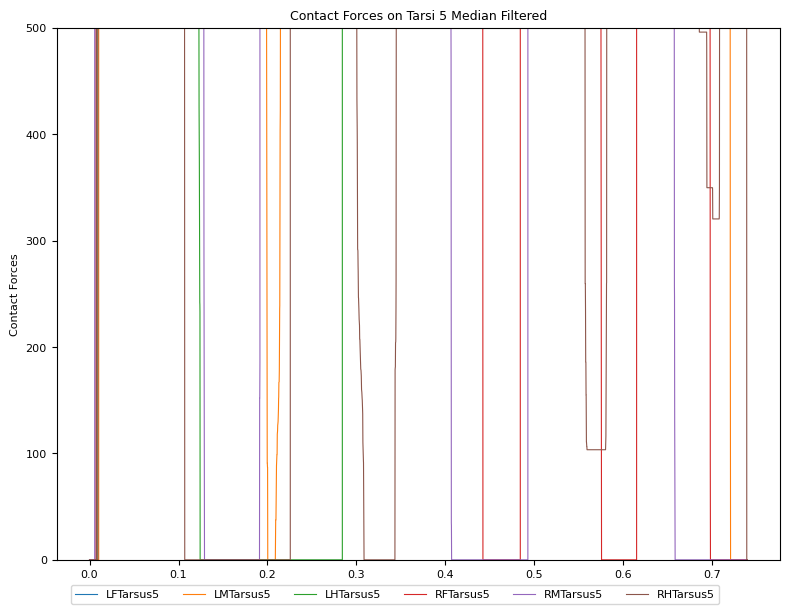

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True, window_size_medfilt= window_size_medfilt)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False, window_size_medfilt=window_size_medfilt)

# Dynamic 

In [36]:
#so that the fly doesnt directly fly away.
adhesion_obs = np.where(np.array(derivative)>= 0, 1, 0)
adhesion_obs[:n_stabilisation_steps] = np.ones(6) 


In [27]:
# Run simulation
window_size_medfilt =1001
obs, info = nmf.reset() 
nmf.physics.model.opt.gravity = (0,0,9.81e5)
adhesion_gain_multiply = 8
old_obs = obs
obs_list = [obs]
deriv_list = []
adhesion_list = []
for i in trange(num_steps + n_stabilisation_steps):
    if bool_sum_of_allTarsi:
        medold = np.median([[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list[-window_size_medfilt-1:-2]], axis = 0)
        mednew = np.median([[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list[-window_size_medfilt:-1]], axis = 0)
        derivative = (mednew-medold) / nmf.timestep
        #print(np.shape(derivative))
    else:
        medold = np.median([obs['contact_forces'][4::5] for obs in obs_list[-window_size_medfilt-1:-2]], axis = 0)
        mednew = np.median([obs['contact_forces'][4::5] for obs in obs_list[-window_size_medfilt:-1]], axis = 0)
        derivative = (mednew-medold) / nmf.timestep
        #print(np.shape(derivative))
        #so that the fly doesnt directly fly away.
    if i == 0:
        derivative = np.zeros(6)
    deriv_list.append(derivative)
    adhesion = np.where(np.array(derivative)>= 0, 1, 0)
        
    #deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    #obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        adhesion = np.ones(6) 
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*adhesion}
    else: 

        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*adhesion} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    #print(derivative)
    adhesion_list.append(adhesion)
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

  0%|          | 0/7390 [00:00<?, ?it/s]

c:\Users\lschwitt\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lschwitt\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7390/7390 [00:45<00:00, 162.73it/s]


In [28]:
np.shape(deriv_list)



(7390, 6)

In [29]:
deriv_list[0][0]

0.0

In [30]:
np.array(deriv_list)[:, 0]

array([ 0., nan,  0., ...,  0.,  0.,  0.])

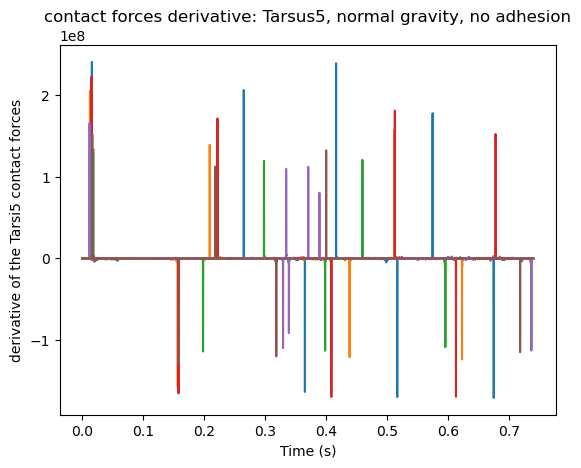

In [31]:
for i in range(6):
    plt.plot(np.arange(len(deriv_list)) * nmf.timestep,
        np.array(deriv_list)[:, i])#,
        #label=touch_sensor_Tarsi5_names[i])
#plt.legend()
plt.xlabel('Time (s)')
if bool_sum_of_allTarsi:
    plt.ylabel('derivative of the sum of all Tarsi contact forces')
    plt.title("contact forces derivative: Tarsus, normal gravity, no adhesion")
else:
    plt.ylabel('derivative of the Tarsi5 contact forces')
    plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

Text(0, 0.5, 'adhesion')

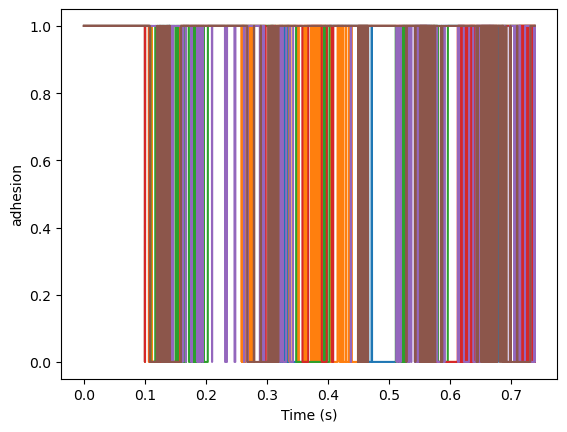

In [32]:
for i in range(6):
    plt.plot(np.arange(len(adhesion_list)) * nmf.timestep,
        np.array(adhesion_list)[:, i])#,
        #label=touch_sensor_Tarsi5_names[i])
#plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('adhesion')
#plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

In [33]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_DYNADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x06`\xfemdat\x00\x…

In [34]:
all_adhesion_bodies = [
    #name of all adhesion actuators
    f'{side}{pos}{dof}' #TO DO: potentiall its just this for the bodies : f'{side}{pos}{dof}' 
    for side in 'LR'
    for pos in 'FMH'
    #for dof in ['Tarsus1', 'Tarsus2', 'Tarsus3', 'Tarsus4', 'Tarsus5']
    for dof in ['Tarsus5']
]

In [35]:
all_adhesion_bodies

['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5']